Checklist
1. Make sure your "Regional Format" is set to "English (United Kingdom)" before Excel opens files that contain English date-like objects,
   if you want them to be parsed as English datetime. English (United States) regional format will convert them to American Datetime as possible.
   You have no way to prevent Excel from converting date-like strings or objects to datetime when opening a file. 

In [1]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import time
import datetime
import re
import os
import glob
import math
import gc

from config import config
import data_helpers

In [2]:
TRAIN_MODE = True
OPERATION = 'TRAIN_C'  # 'PRETRAIN'  'TRAIN_C'   'FINETUNE'   'TEST'

TEST_ID = 'SM.14'

STARTING_PERCENT = 0
ENDING_PERCENT = 0
TRAIN_PERCENT= 94   # chronically the earliest part over the databased past rows.  In the end of this part, there is BACK part with the same size as VALID part.
VALID_PERCENT = 4   # chronically the next part to train part over the databased past rows
TEST_PERCENT = 100 - TRAIN_PERCENT - VALID_PERCENT # chronically the last part over the databased past rows. This part will be added with post-database rows, either past or known coming

BUFFER_SIZE = 35000
BATCH_SIZE = 8

TEAM_EMBS = 50  #
DECODE_BASE_DATE = False
EMBED_AB_COLS = True    # True: Pls choose a small LR so that we have plenty of train epochs and the embedded values have enough chance to seek their proper places.
ADDITIONAL_D_MODEL = 0   #------------ Try increase it when underfitting.

TRANSFORMER_LAYERS = 6
TRANSFORMER_HEADS = 60
DROPOUT = 0.0
ADAPTORS_LAYERS = 10
NORMALIZATION_FREQ = 3

# This is an exponential curve that hits STARTING_LEARNING_RATE at step zero and EXAMPLE_LEARNING_RATE at step EXAMPLE_LEARNING_STEP.
# lr(step) = STARTING_LEARNING_RATE * pow( pow(EXAMPLE_LEARNING_RATE/STARTING_LEARNING_RATE, 1/EXAMPLE_LEARNING_STEP), step )
STARTING_LEARNING_RATE = 1.5e-6
EXAMPLE_LEARNING_RATE = STARTING_LEARNING_RATE * 0.05
EXAMPLE_LEARNING_STEP = 30  

VECTOR_BETTING = True

In [3]:
COUNTRY = 'England'
NUMBER_BOOKIES = (3-1)  # Take William Hills, Bet&Win, and Bet365. Other bookies' odds list change over years and leagues.
BOOKIE_TO_EXCLUDE = ['BW']    # 'BWIN' odds don't show up since mid Febrary 2025. This may reduce the effective NUMBER_BOOKIES.
DIVIISONS = ['E0', 'E1', 'E2', 'E3']    # 'EC', the Conference league, is excluded as some odds makers are not archived for the league since 2013.

"""
#-------------------- England ---------------------
Time range of data: 2004/2005 - 2024/2025
Leagues - Premiere, League 1, League 2, Championship, Conference (dropped out)
!!! Conference will be dropped out because they lack Shoot_cols and ShootT_cols since 2026. Those columns are important.
Bookies - Bookie1 : WH(William Hills), Bookie2: BW(Bet&Win), Bookie3 : B365(Bet365), Bookie4 : Mixed
William Hills, Bet365 on Premier: https://www.oddschecker.com/football/english/premier-league
William Hills, Bet365 on Championship: https://www.oddschecker.com/football/english/championship
William Hills, Bet365 on League-1: https://www.oddschecker.com/football/english/league-1
William Hills, Bet365 on League-2: https://www.oddschecker.com/football/english/league-2
William Hills, Bet365 on Conference: https://www.oddschecker.com/football/english/non-league/national-league
BWin(Bet&Win) on Premier and Chanpionship: https://sports.bwin.fr/fr/sports/football-4/paris-sportifs/angleterre-14
"""

# COUNTRY = 'Scotland'
# NUMBER_BOOKIES = 3  # Take ...

'\n#-------------------- England ---------------------\nTime range of data: 2004/2005 - 2024/2025\nLeagues - Premiere, League 1, League 2, Championship, Conference (dropped out)\n!!! Conference will be dropped out because they lack Shoot_cols and ShootT_cols since 2026. Those columns are important.\nBookies - Bookie1 : WH(William Hills), Bookie2: BW(Bet&Win), Bookie3 : B365(Bet365), Bookie4 : Mixed\nWilliam Hills, Bet365 on Premier: https://www.oddschecker.com/football/english/premier-league\nWilliam Hills, Bet365 on Championship: https://www.oddschecker.com/football/english/championship\nWilliam Hills, Bet365 on League-1: https://www.oddschecker.com/football/english/league-1\nWilliam Hills, Bet365 on League-2: https://www.oddschecker.com/football/english/league-2\nWilliam Hills, Bet365 on Conference: https://www.oddschecker.com/football/english/non-league/national-league\nBWin(Bet&Win) on Premier and Chanpionship: https://sports.bwin.fr/fr/sports/football-4/paris-sportifs/angleterre-1

In [4]:
# For serendipity
seed = 23
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

In [5]:
ODDS_COLS = []
for b in range(NUMBER_BOOKIES):
    ODDS_COLS += ['HDA'+str(b)+'H', 'HDA'+str(b)+'D', 'HDA'+str(b)+'A']

In [6]:
id_cols = ['id']
Div_cols = ['Div']
Date_cols = ['Date']
Team_cols = ['HomeTeam', 'AwayTeam']
Odds_cols = ODDS_COLS
BB_cols = id_cols + Div_cols + Date_cols + Team_cols + Odds_cols

Half_Goal_cols = ['HTHG', 'HTAG']
Full_Goal_cols = ['FTHG', 'FTAG']
Goal_cols = Half_Goal_cols + Full_Goal_cols
Shoot_cols = ['HS', 'AS']
ShootT_cols = ['HST', 'AST']
Corner_cols = ['HC', 'AC']
Faul_cols = ['HF', 'AF']
Yellow_cols = ['HY', 'AY']    # H/A Yellow Cards, H/A Red Cards
Red_cols = ['HR', 'AR']    # H/A Yellow Cards, H/A Red Cards
AB_cols = Half_Goal_cols + Full_Goal_cols + Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols + Red_cols
Required_Non_Odds_cols = Div_cols + Date_cols + Team_cols + Half_Goal_cols + Full_Goal_cols + Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols + Red_cols

# underscore_prefixed lists have discontinued columns.
BBAB_cols = BB_cols + AB_cols

# Make sure Odds_cols comes first !!!
if EMBED_AB_COLS: _Cols_to_Standardize = Odds_cols
else: _Cols_to_Standardize = Odds_cols + AB_cols

_Label_cols = Full_Goal_cols + Odds_cols


In [7]:
print(BBAB_cols)
print(BB_cols)
print(_Label_cols)

['id', 'Div', 'Date', 'HomeTeam', 'AwayTeam', 'HDA0H', 'HDA0D', 'HDA0A', 'HDA1H', 'HDA1D', 'HDA1A', 'HTHG', 'HTAG', 'FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC', 'HF', 'AF', 'HY', 'AY', 'HR', 'AR']
['id', 'Div', 'Date', 'HomeTeam', 'AwayTeam', 'HDA0H', 'HDA0D', 'HDA0A', 'HDA1H', 'HDA1D', 'HDA1A']
['FTHG', 'FTAG', 'HDA0H', 'HDA0D', 'HDA0A', 'HDA1H', 'HDA1D', 'HDA1A']


In [8]:
print(_Cols_to_Standardize)

['HDA0H', 'HDA0D', 'HDA0A', 'HDA1H', 'HDA1D', 'HDA1A']


In [9]:
def get_std_size():
    size = 0
    for cols in _Cols_to_Standardize:
        size += len(cols)
    return size

def get_standardization_params(df_grown):
    
    def get_mean_and_std(col):
        array = df_grown[col]
        array = np.array(array)
        return (array.mean(), array.std(), np.max(array))
    
    params = {}
    for col in _Cols_to_Standardize:
        params[col] = get_mean_and_std(col)

    return params


def check_standardization(bbab, std_params):
    for col in _Cols_to_Standardize:
        start = BBAB_cols.index(col)
        (mean, std, maximum) = std_params[col]
        if -mean/std > bbab[start] + 1e-5:
            print('standardization error 1', col, -mean/std, bbab[start])
        if max(bbab[start]) > (maximum - mean) / std + 1e-5:
            print('standardization error 2', col, bbab[start], (maximum - mean) / std)

In [10]:
countryDirPath = "./data/football-data-co-uk/" + COUNTRY
data_helpers.assign_seasonal_filenames(countryDirPath)
df_grown, df_new = data_helpers.get_grown_and_new_from_football_data(countryDirPath, Required_Non_Odds_cols, NUMBER_BOOKIES, oddsGroupsToExclude = BOOKIE_TO_EXCLUDE, train_mode = TRAIN_MODE, skip=True)
if df_grown is not None: print("df_grown: ", df_grown.shape)
if df_new is not None: print("df_new: ", df_new.shape)

files found to rename:  0
total rows in renamed files:  0
df_grown:  (41248, 29)
df_new:  (0, 29)


In [11]:
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)

def createSimpleTokenizer(corpus_files, vocab_size, unknown_token, special_tokens):
        tokenizer = Tokenizer(models.WordLevel(unk_token=unknown_token))
        tokenizer.normalizer = normalizers.Sequence([normalizers.NFD(), normalizers.Lowercase(), normalizers.StripAccents()])
        tokenizer.pre_tokenizer = pre_tokenizers.WhitespaceSplit()
        trainer = trainers.WordLevelTrainer(vocab_size=vocab_size, special_tokens=special_tokens)
        tokenizer.train(corpus_files, trainer=trainer)
        tokenizer.decoder = decoders.WordPiece(prefix=" ")
        return tokenizer

def creat_team_tokenizer_uk(df_grown):
    teams = list(set(list(df_grown['HomeTeam']) + list(df_grown['AwayTeam'])))
    teams_string = [str(team) for team in teams]
    teams_string = [re.sub(r"\s", "_", item) for item in teams_string]    # replace spaces with a '_'
    teams_text = " ".join(teams_string)

    corpus_file = os.path.join(countryDirPath, '_tokenizers', 'team_ids_text_uk.txt')
    f = open(corpus_file, "w+", encoding="utf-8")
    f.write(teams_text)
    f.close()

    corpus_files = [corpus_file]
    unknown_token = config['unknown_token']
    special_tokens = [unknown_token] ################### + ["[HOME]", "[AWAY]"]
    vocab_size = len(teams_string) + len(special_tokens)

    tokenizer_team = createSimpleTokenizer(corpus_files, vocab_size, unknown_token, special_tokens)
    return tokenizer_team

In [12]:
tokenizer_team = creat_team_tokenizer_uk(df_grown)
print(tokenizer_team.get_vocab_size())

teams = ['Tottenham', 'Arsenal', 'Liverpool', 'what?', 'Tottenham', 'Chelsea', 'e_t', 'Man United', '1234', '[HOME]', '[AWAY]']
teams = [team.strip() for team in [re.sub(r"\s", "_", item) for item in teams]]
teams = " ".join(teams)
encoding = tokenizer_team.encode(teams)
# encoding = tokenizer.encode("")
print(encoding.tokens)
print(encoding.type_ids)
print(encoding.ids)

tokenizer_team.decode(encoding.ids)

114
['tottenham', 'arsenal', 'liverpool', '[UNK]', 'tottenham', 'chelsea', '[UNK]', 'man_united', '[UNK]', '[UNK]', '[UNK]']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[102, 4, 59, 0, 102, 28, 0, 63, 0, 0, 0]


'tottenham arsenal liverpool tottenham chelsea man_united'

In [13]:
#================= build_id_to_ids.ipynb

QUALITY = 75

targetLength = 300          # A target game will be explained by maximum 'targetLength' count of past games.
minCurrent = 1e-7
sinceDaysAgo = 365 * 20     # A target game will be explained by past games that took place since 'sinceDaysAgo' days ago. 
qualityPct = QUALITY        #
conductance365 = 0.9        # 0.9 comes from test.
chooseDivs=False

id_to_ids_filename = str(targetLength) + '-' + str(minCurrent) + '-' + str(sinceDaysAgo) + '-' + str(qualityPct) + '-' + str(conductance365) + '-' + str(chooseDivs)
id_to_ids_filePath = os.path.join(countryDirPath, '_id_to_ids', id_to_ids_filename + ".json")

id_to_ids_existing = None
id_to_ids_existing = data_helpers.LoadJsonData(id_to_ids_filePath)
tf_total = df_grown; df_search = df_grown
id_to_ids = data_helpers.fixture_id_to_ids_uk_maxflow(countryDirPath, targetLength, minCurrent, sinceDaysAgo, qualityPct, conductance365, tf_total, df_search, chooseDivs=chooseDivs)
data_helpers.SaveJsonData(id_to_ids, id_to_ids_filePath)

print(len(id_to_ids))

41248


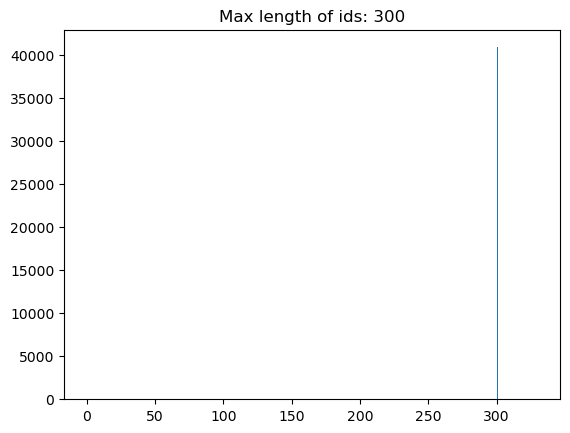

In [14]:
lengths = [len(ids) for (tag, label, ids) in id_to_ids.values()]
maxLen = max(lengths)
plt.hist(lengths, np.linspace(0, int(maxLen*1.1), int(maxLen*1.1) + 1))
plt.ylim(plt.ylim())
maxLen = max(lengths)
# plt.plot([maxLen, maxLen], plt.ylim())
plt.title(f'Max length of ids: {maxLen}')

lengths = [len(ids) for (tag, label, ids) in id_to_ids.values()]
maxLen = max(lengths)
plt.hist(lengths, np.linspace(0, int(maxLen*0.9), int(maxLen*0.9) + 1))
plt.ylim(plt.ylim())
maxLen = max(lengths)
# plt.plot([maxLen, maxLen], plt.ylim())
plt.title(f'Max length of ids: {maxLen}')

MAX_TOKENS = maxLen

In [15]:
def normalize_raw_bbab(bbab, tokenizer_team, std_params, train_mode=True):

    label = []
    if train_mode:
        #---------------------- label, before changing bbab
        for col in _Label_cols:
            start = BBAB_cols.index(col)
            label.append(bbab[start])

    #----------------------- 
    start = BBAB_cols.index(Div_cols[0])
    Div = bbab[start]
    bbab[start] = DIVIISONS.index(Div)  # Assumes no n/a

    start = BBAB_cols.index(Team_cols[0]); end = BBAB_cols.index(Team_cols[-1]) + 1
    pair_str = [str(team) for team in bbab[start : end]]    # Team names are already normalized, removing/striping spaces.
    pair_text = " ".join(pair_str)
    pair_tokens = tokenizer_team.encode(pair_text).ids
    bbab[start : end] = pair_tokens # 0 for Unknown, by tokenizer trainig.

    #--------------------- standardize
    for col in _Cols_to_Standardize:    #   _Cols_to_Standardize has some of BB_cols.
        if not train_mode and col not in BB_cols: continue

        (mean, std, maximum) = std_params[col]
        # assert 0 <= bbab[start]
        start = BBAB_cols.index(col)
        bbab[start] = (bbab[start] - mean) / std
        # assert - mean/std <= bbab[start]
        # assert max(bbab[start : end]) <= (maximum - mean) / std
        # print('std', bbab[start : end])

    #--------------------- columns for positional embedding
    start = BBAB_cols.index(Date_cols[0])   #
    date = bbab[start]
    bbab[start] = (datetime.datetime.combine(date, datetime.time(0,0,0)) - config['baseDate']).days  # either positive or negative

    #---------------------- bb only
    start = BBAB_cols.index(BB_cols[0]); end = start + len(BB_cols)     # 
    bb = bbab[start : end]

    return bbab, bb, label, date

def getDateDetails(date):
    baseYear = config['baseDate'].year
    date_details = tf.Variable([date.year - baseYear, date.month, date.day, date.weekday()], dtype=tf.int32)
    return date_details     # (4,)

filler = tf.zeros_like([0] * len(BBAB_cols), dtype=tf.float32)

def get_data_record(df_total, baseId, ids, tokenizer_team, std_params, train_mode=True):
    # try:
        # base_bbab = list(df_grown.loc[df_grown['id'] == baseId, BBAB_cols])
        if train_mode:
            base_bbab = list(df_total[df_total['id'] == baseId][BBAB_cols].iloc[0, :])  # base_bbab follows BBAB. list
        else:
            base_bbab = list(df_total[df_total['id'] == baseId][BB_cols].iloc[0, :])  # base_bbab follows BB. list

        base_bbab, base_bb, base_label, base_date = normalize_raw_bbab(base_bbab, tokenizer_team, std_params, train_mode=train_mode)
        # base_bbab, base_bb, base_label, base_date
        # print('2', base_bbab)
        baseId = tf.Variable(baseId, dtype=tf.int32)
        base_bbab = tf.Variable(base_bbab, dtype=tf.float32)    # (len(BBAB_cols),)
        base_bb = tf.Variable(base_bb, dtype=tf.float32)        # (len(BB_cols),)
        base_label = tf.Variable(base_label, dtype=tf.float32)  # (len(_Label_cols),)
        # print('3', base_bbab)
        # Default sequence.
        sequence = tf.transpose(tf.Variable([[]] * len(BBAB_cols), dtype=tf.float32))   # (0, len(BBAB_cols))
        # sequence = np.array([[]] * len(BBAB_cols), dtype=config['np_float']).T
        # print('3.5', sequence)
        baseDateDetails = getDateDetails(base_date) # (4,)

        concat = []
        for id in ids:
            bbab = list(df_total[df_total['id'] == id][BBAB_cols].iloc[0, :])   # bbab follows BBAB. list
            # print('4', bbab)
            bbab, _, _, _ = normalize_raw_bbab(bbab, tokenizer_team, std_params, train_mode=train_mode)   # bbab follows BBAB. list
            # check_standardization(bbab, std_params)

            bbab = tf.Variable(bbab, dtype=tf.float32)[tf.newaxis, :]       # (1, len(BBAB_cols))
            # _bbab = bbab[0].numpy()
            # check_standardization(_bbab, std_params)

            concat.append(bbab)     # concat doesn't create a new axis.

        if len(concat) > 0:
            sequence = tf.concat(concat, axis=0)    # (nSequence, len(BBAB_cols))
            # if sequence.shape[0] > 0:
            #     bbab = sequence[0].numpy()
            #     check_standardization(bbab, std_params)

        seq_len_org = sequence.shape[0]
        nMissings = MAX_TOKENS - seq_len_org
        if nMissings > 0:
            patch = tf.stack([filler] * nMissings, axis=0)
            sequence = tf.concat([sequence, patch], axis=0)     # concat doesn't create a new axis. (MAX_TOKENS, len(BBAB_cols))
        base_bb = base_bb[tf.newaxis, :]    # shape: (seq_len = 1, len(BBAB_cols))
        baseDateDetails = baseDateDetails[tf.newaxis, :]
        mask = tf.Variable([1] * seq_len_org + [0] * nMissings, dtype=tf.int32) # (MAX_TOKENS,) ## DO NOT USE tf.constant !!! unstable.
        mask = mask[:, tf.newaxis] & mask[tf.newaxis, :]    # (MAX_TOKENS, MAX_TOKENS)

        return (baseId, sequence, base_bb, base_label, baseDateDetails, mask)


def generate_dataset_uk(df_total, fixture_id_to_ids, tokenizer_team, std_params, train_mode=True):
    def generator():
        count = 0
        for baseId, (tag, label, ids) in fixture_id_to_ids.items():
            baseId = int(baseId)
            baseId, sequence, base_bb, base_label, baseDateDetails, mask = get_data_record(df_total, baseId, ids, tokenizer_team, std_params, train_mode=train_mode)
            print("count: {}, baseId: {}".format(count, baseId), end='\r'); count += 1
            # if count > 200: break
            yield (baseId, sequence, base_bb, base_label, baseDateDetails, mask)

    ds = tf.data.Dataset.from_generator(
        generator,
        output_types=(tf.int32, tf.float32, tf.float32, tf.float32, tf.int32, tf.int32),
        output_shapes=(tf.TensorShape(()), tf.TensorShape((MAX_TOKENS, len(BBAB_cols))), tf.TensorShape((1, len(BB_cols),)), tf.TensorShape((len(_Label_cols),)), tf.TensorShape((1, 4)), tf.TensorShape((MAX_TOKENS, MAX_TOKENS))),
        args=()
    )
    return ds
   
def X_versus_Y(baseId, sequence, base_bb, base_label, baseDateDetails, mask):
    return (baseId, sequence, base_bb, baseDateDetails, mask), (base_label)

# I found, in PositionalEmbedding, batch size ranges between 3, 4, 6 and 8, while they should be 4 or 8, except margial rows. Check it.
train_batch_size = BATCH_SIZE
test_batch_size = BATCH_SIZE * 2

def apply_train_pipeline(ds):
    return (
        ds
        .shuffle(BUFFER_SIZE)       # Shuffle the training dataset.
        .batch(train_batch_size)
        .map(X_versus_Y, tf.data.AUTOTUNE)
        .cache()
        .prefetch(buffer_size=tf.data.AUTOTUNE)
        )

def apply_test_pipeline(ds):
    return (
        ds
        .batch(test_batch_size)
        .map(X_versus_Y, tf.data.AUTOTUNE)
        .cache()
        .prefetch(buffer_size=tf.data.AUTOTUNE)
        )

In [16]:
std_path = os.path.join(countryDirPath, '_datasets', id_to_ids_filename + '-normalization' + ".json")
std_params = get_standardization_params(df_grown)
print(std_params)
data_helpers.SaveJsonData(std_params, std_path)
std_params = data_helpers.LoadJsonData(std_path)

{'HDA0H': (2.4119683378588057, 1.051541750300173, 21.0), 'HDA0D': (3.4450579422032583, 0.5770603678069028, 15.0), 'HDA0A': (3.6796494375484876, 2.1308711773972195, 46.0), 'HDA1H': (2.4495740157098527, 1.107640269795148, 23.0), 'HDA1D': (3.603998496896818, 0.6490740896637591, 17.0), 'HDA1A': (3.8159252084949564, 2.2283633497565676, 41.0)}


In [17]:
# if TRAIN_MODE:
#     ds_path = os.path.join(countryDirPath, '_datasets', id_to_ids_filename + '-dataset')

#     if os.path.exists(ds_path):
#         ds = tf.data.Dataset.load(ds_path)
#     else:
#         ds = generate_dataset_uk(df_grown, id_to_ids, tokenizer_team, std_params)
#         tf.data.Dataset.save(ds, ds_path)       # This is the true line by which the dataset generator gets to work.
#         ds = tf.data.Dataset.load(ds_path)      # Weird, this line is required. len(ds) would have no value!!!

#     len(ds)

In [18]:
baseIds = [int(id) for (id, value) in id_to_ids.items()]
print(min(baseIds), max(baseIds))

1000001 1041845


In [19]:
if TRAIN_MODE:
    ds_path = os.path.join(countryDirPath, '_datasets', id_to_ids_filename + '-dataset')

    if os.path.exists(ds_path):
        ds = tf.data.Dataset.load(ds_path)
        lastPart = ds.skip(len(ds)-1).take(1)
        lastElem = None; 
        for elem in lastPart: lastElem = elem; break
        (lastId, _, base_bb, _, _, _) = lastElem
        lastId = lastId.numpy(); base_bb = base_bb.numpy()
        assert lastId == max(df_grown['id'])
        print("max_id in the existing dataset is {}". format(lastId))
        # print("For your information: base_bb = ", base_bb)
        new_id_to_ids = {key: value for (key, value) in id_to_ids.items() if lastId < int(key)}
        if len(new_id_to_ids) > 0:
            print("{} A dataset of new records are being generated...")
            ds_new = generate_dataset_uk(df_grown, new_id_to_ids, tokenizer_team, std_params)
            print("The dateset is being appended to the exsiting dataset...")
            ds = ds.concatenate(ds_path) # tf.data.Dataset.zip((ds, ds_new))
            tf.data.Dataset.save(ds, ds_path)       # This is the true line by which the dataset generator gets to work.
            ds = tf.data.Dataset.load(ds_path)      # Weird, this line is required. len(ds) would have no value!!!
        else:
            print("No new records generated.")
    else:
        ds = generate_dataset_uk(df_grown, id_to_ids, tokenizer_team, std_params)
        tf.data.Dataset.save(ds, ds_path)       # This is the true line by which the dataset generator gets to work.
        ds = tf.data.Dataset.load(ds_path)      # Weird, this line is required. len(ds) would have no value!!!

    len(ds)

max_id in the existing dataset is 1041845
No new records generated.


In [20]:
total_size = len(ds)

starting_size = int(STARTING_PERCENT/100 * total_size)
ending_size = int(ENDING_PERCENT/100 * total_size)
take_size = total_size - starting_size - ending_size
remaining_ds = ds.skip(starting_size)
dataset = remaining_ds.take(take_size)          # starting | dataset | ending

dataset_size = len(dataset)
train_size = int(TRAIN_PERCENT/100 * dataset_size)
valid_size = int(VALID_PERCENT/100 * dataset_size)
test_size = dataset_size - train_size - valid_size      # len(dataset) = train_size + valid_size + tast_size        NO back_size
train_ds = dataset.take(train_size)                    # dataset[: train_size]
remaining_ds = dataset.skip(train_size - valid_size)    # dataset[train_size - valid_size: ]
back_ds = remaining_ds.take(valid_size)                # dataset[train_size - valid_size: train_size]
remaining_ds = remaining_ds.skip(valid_size)            # dataset[train_size: ]
valid_ds = remaining_ds.take(valid_size)               # dataset[train_size, train_size + valid_size]
remaining_ds = remaining_ds.skip(valid_size)                # dataset[train_size + valid_size :]
test_ds = remaining_ds.take(test_size)
backtest_ds = valid_ds.concatenate(test_ds) # tf.data.Dataset.zip((valid_ds, test_ds))

assert len(test_ds) == test_size
assert dataset_size == len(train_ds) + len(valid_ds) + len(test_ds)

print("total_size, dataset, train_ds, back_ds, valid_ds, test_ds, backtest_ds: ", \
      total_size, len(dataset), len(train_ds), len(back_ds), len(valid_ds), len(test_ds), len(backtest_ds))

total_size, dataset, train_ds, back_ds, valid_ds, test_ds, backtest_ds:  41248 41248 38773 1649 1649 826 2475


In [21]:
def find_first_baseDateDetails(ds):
    baseId = baseDateDetails = None
    for z in ds:
        baseId, _, _, _, baseDateDetails, _, _ = z
        break
    return baseId.numpy(), baseDateDetails.numpy()
# print("train_ds's first game: ", find_first_baseDateDetails(train_ds))
# print("back_ds's first game: ", find_first_baseDateDetails(back_ds))
# print("valid_ds's first game: ", find_first_baseDateDetails(valid_ds))
# print("test_ds's first game: ", find_first_baseDateDetails(test_ds))
"""
train_ds's first game:  (1000001, array([[4, 8, 7, 5]]))
back_ds's first game:  (1037717, array([[23,  2, 18,  5]]))
valid_ds's first game:  (1039366, array([[23, 12, 22,  4]]))
test_ds's first game:  (1041019, array([[24, 11,  2,  5]]))
"""

"\ntrain_ds's first game:  (1000001, array([[4, 8, 7, 5]]))\nback_ds's first game:  (1037717, array([[23,  2, 18,  5]]))\nvalid_ds's first game:  (1039366, array([[23, 12, 22,  4]]))\ntest_ds's first game:  (1041019, array([[24, 11,  2,  5]]))\n"

In [22]:

train_batches = apply_train_pipeline(train_ds)

In [23]:
cnt = 5
for z in train_batches:
    (baseId, sequence, base_bb, baseDateDetails, mask), (base_label) = z
    cnt -= 1 
    if cnt == 0: break
print(baseId.shape, sequence.shape, base_bb.shape, mask.shape, base_label.shape, baseDateDetails.shape)
sample_x = (sequence, base_bb, baseDateDetails, mask)
sample_y = (base_label)
# print(baseId.numpy(), base_bb.numpy(), baseDateDetails.numpy()) 

(8,) (8, 300, 27) (8, 1, 11) (8, 300, 300) (8, 8) (8, 1, 4)


In [24]:
back_batches = apply_test_pipeline(back_ds)
valid_batches = apply_test_pipeline(valid_ds)
test_batches = apply_test_pipeline(test_ds)
backtest_batches = apply_test_pipeline(backtest_ds)

In [25]:
def positional_encoding(positions, d_model):     # positions.shape = (batch, seq_len). d_model is a positive even integer.
    # positions[b, :] = [dago_299, dago_298, ..., dago_0] = eg [6, 7, ..., 1611]

    years = 25
    quotient = 365 * years / d_model   # 325 * 25 is total days during 25 years since 2024 (the earliest data year). 
    fractional_pos = positions / quotient  # (batch, seq_len). max << d_model.  lower=0, upper<<d_model
    depth = d_model/2   #
    depths = tf.range(depth, dtype=tf.float32) / depth  # (depth,). [0/depth, 1/depth, ..., (depth-1)/depth]

    # Why do we use this specific formula for depths, while any formula will work?
    # depths will be multiplied by fractional_pos, which may have ever large number.
    # We want the product to be limited, and depths should converge to zero to limit the product.
    # If it cenverges to zero too fast, though, the generated pos_encoding will have little representative power as positional representation.
    # Why, then, do we want to limit the product?
    # The product visiting many different values will be enough for us. The solution is to let them go to zero, from a significant value.
    BIG = d_model * 1.0 * 0.8     # let it be float.
    depths = 1.0 / tf.pow(BIG, depths)        # 1 / [1, ..., BIG ** ((depth-1)/depth)] = [1, ..., >1/BIG]

    # Why fractional_pos is multiplied linearly?
    # Because (sin(A+a), cos(A+a)) is a rotation of (sin(A), cos(A)), no matter what depths is.
    angle_rads = fractional_pos[:, :, tf.newaxis] * depths  # [0, ..., <<d_model ] * [ 1, ..., >1/BIG]. 
    # Interleaving sin and cos is equivalent to seperated sin and cos.
    # pos_encoding = rearrange([tf.math.sin(angle_rads), tf.math.cos(angle_rads)], 'w b p d -> w h (w t)')  # Interleaving sin and cos. (batch, seq_len, d_model)
    pos_encoding = tf.concat([tf.math.sin(angle_rads), tf.math.cos(angle_rads)], axis=-1)   # Seperated sin and cos. (batch, seq_len, d_model)
    return pos_encoding  # (batch, seq_len, d_model)

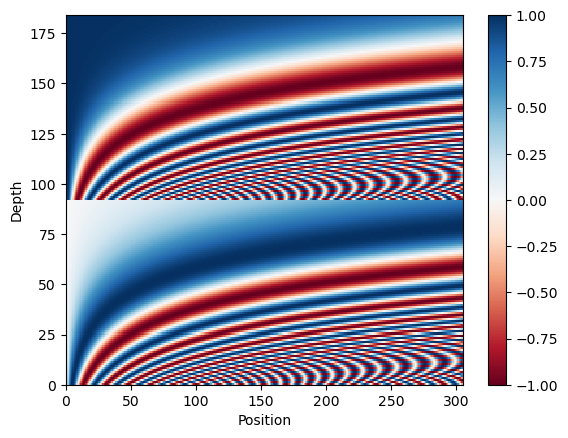

In [26]:
years = 15
seq_len = 300
d_model = 184
positions = tf.Variable([[i for i in range(0, 365 * years, int(365 * years / seq_len))] for batch in range(100)], dtype=tf.float32)
# positions = tf.ones((100, 200), dtype=tf.float32) * tf.range(200, dtype=tf.float32)
pos_encoding = positional_encoding(positions, d_model=d_model)
# print('pos_encoding', pos_encoding.shape)
pos_encoding = pos_encoding[0, :, :]
# print(pos_encoding.shape)
# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [27]:

class hParams:    
    nDivisions = len(DIVIISONS)
    division_embs = 4

    nTeams = tokenizer_team.get_vocab_size()    # including Unknown
    team_embs = TEAM_EMBS
    nGoals  = 4  # [0, 1, 2, 3] Maximum nGoals goals for a team in each of 1st and 2nd halfs. Extra goals will be clipped_by_value.
    goal_embs = 4
    nShoots = 21    # [0, ..., 20]
    shoot_embs = 4 # for combination
    nShootTs = 11   # [0, ..., 10]
    shootT_embs = 4 # for combination
    nCorners = 11   # [0, ..., 10]
    corner_embs = 4 # for combination
    nFauls = 21     # [0, ..., 20]
    faul_embs = 2 # for combination
    nYellows = 5    # [0, ..., 4]
    yellow_embs = 2 # for combination
    nReds = 2       # [0, 1]
    red_embs = 2
    
    batch_size = BATCH_SIZE
    days_spanning_years = 30
    num_layers = TRANSFORMER_LAYERS
    num_heads = TRANSFORMER_HEADS
    m365_size = 1
    initial_m365 = 0.9

    # d_model DEPENDS...
    # We want as small d_model as possible, because from which we can freely choose an actual d_model.
    # Tests seem to indicate that larger d_model leads to training overfitting and validation underfitting.
    d_model = 1 * division_embs + 2 * team_embs + 3 * NUMBER_BOOKIES
    d_encoder = d_decoder = 0
    if EMBED_AB_COLS:
        d_encoder = d_model + 1 * goal_embs + 1 * goal_embs + 1 * (shoot_embs + shootT_embs + corner_embs + faul_embs + yellow_embs + red_embs)
        d_decoder = d_model + 2 * 4     # 2 * 4 : date details
    else:   # This mode, EMBED_AB_COLS = False, gives much smaller d_moddel, maybe avoiding overfitting.
        d_encoder = d_model + 2 * 8     # 2 * 8 : bb_cols
        d_decoder = d_model + 2 * 4     # 2 * 4 : date details
    d_model = max(d_encoder, d_decoder)     # (136, 118) for EMBED_AB_COLS, (126, 118) for False EMBED_AB_COLS
    d_model += ADDITIONAL_D_MODEL               # Adjust for the model size and overfitting.
    d_model = d_model + d_model % 2     # make it an even number.
    print("d_model: ", d_model)

d_model:  136


In [28]:
class PositionalEmbedding(tf.keras.layers.Layer):

    def __init__(self, hParams, isEncoder=True):
        super().__init__()
        self.isEncoder = isEncoder

        # game
        self.division_emb = tf.keras.layers.Embedding(hParams.nDivisions, hParams.division_embs, dtype=tf.float32, mask_zero=False) # Learn Unknown
        self.team_emb = tf.keras.layers.Embedding(hParams.nTeams, hParams.team_embs, dtype=tf.float32, mask_zero=False) # Learn Unknown

        if EMBED_AB_COLS:
            # AB_cols
            self.firstH_goal_emb = tf.keras.layers.Embedding(hParams.nGoals * hParams.nGoals, hParams.goal_embs, dtype=tf.float32, mask_zero=False)
            self.secondH_goal_emb = tf.keras.layers.Embedding(hParams.nGoals * hParams.nGoals, hParams.goal_embs, dtype=tf.float32, mask_zero=False)
            self.shoot_emb = tf.keras.layers.Embedding(hParams.nShoots * hParams.nShoots, hParams.shoot_embs, dtype=tf.float32, mask_zero=False)
            self.shootT_emb = tf.keras.layers.Embedding(hParams.nShootTs * hParams.nShootTs, hParams.shootT_embs, dtype=tf.float32, mask_zero=False)
            self.corner_emb = tf.keras.layers.Embedding(hParams.nCorners * hParams.nCorners, hParams.corner_embs, dtype=tf.float32, mask_zero=False)
            self.faul_emb = tf.keras.layers.Embedding(hParams.nFauls * hParams.nFauls, hParams.faul_embs, dtype=tf.float32, mask_zero=False)
            self.yellow_emb = tf.keras.layers.Embedding(hParams.nYellows * hParams.nYellows, hParams.yellow_embs, dtype=tf.float32, mask_zero=False)
            self.red_emb = tf.keras.layers.Embedding(hParams.nReds * hParams.nReds, hParams.red_embs, dtype=tf.float32, mask_zero=False)

        # base_date
        self.day_emb = tf.keras.layers.Embedding(31, 2, dtype=tf.float32, mask_zero=False)
        self.month_emb = tf.keras.layers.Embedding(12, 2, dtype=tf.float32, mask_zero=False)
        self.wday_emb = tf.keras.layers.Embedding(7, 2, dtype=tf.float32, mask_zero=False)

        self.position_permuting_encoding = tf.keras.layers.Dense(hParams.d_model)
        self.position_permuting_decoding = tf.keras.layers.Dense(hParams.d_model)

        self.idx_Days = BB_cols.index('Date')

    def representDateDetails(self, dateDetails):
        # dateDetails: (batch, 1, 4)
        bYears, bMonths, bDays, bWDays = tf.split(dateDetails, [1, 1, 1, 1], axis=-1)   # All should be of (batch, seq_len = 1, 1)
        bYears = tf.cast(bYears, dtype=tf.float32)  # (batch, seq_len = 1, 1)
        bDays = self.day_emb(bDays)[:, :, -1]       # (batch, seq_len = 1, embs = 2)
        bMonths = self.month_emb(bMonths)[:, :, -1] # (batch, seq_len = 1, embs = 2)
        bWDays = self.wday_emb(bWDays)[:, :, -1]    # (batch, seq_len = 1, embs = 2)
        # w = tf.Variable(np.math.pi / 25, dtype=tf.float32)    # 25 years are covered by pi or a half circle.
        w = np.math.pi / 25
        bYearsCos = tf.math.cos(bYears * w)
        bYearsSin = tf.math.sin(bYears * w)
        bYears = tf.concat([bYearsCos, bYearsSin], axis=-1)   # (batch, seq_len = 1, 1+1 = 2)
        return bYears, bMonths, bDays, bWDays

    def combined_embeddings_of_double_columns(self, emb_layer, columns, nValues):
        # Assume emb_layer = Embedding(nValues * nValues, embs, mask_zero=False)
        cols = tf.cast(columns, dtype=tf.int32)
        cols = tf.clip_by_value(cols, 0, nValues-1)
        combi = cols[:, :, 0] * nValues + cols[:, :, 1]   # (batch, seq_len, 1). [0, ..., nValues * nValues - 1]
        combi = emb_layer(combi)
        return combi    # (batch, seq_len, 1)

    def call(self, x):
        (sequence, base_bb, baseDateDetails, mask) = x # sob = sequence or base_bb
        sequenceDays = sequence[:, :, self.idx_Days]  # (batch, seq_len)
        baseDays = base_bb[:, :, self.idx_Days]   # (batch, 1)

        # sequence follows BBAB, whereas base_bb follows 
        
        # BB_cols = id_cols + Div_cols + Date_cols + Team_cols + Odds_cols
        # AB_cols = Goal_cols + Result_cols + Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols + Red_cols

        if self.isEncoder:
            # ramainder: Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols + Red_cols  --- total 12 fields.
            id, div, days, teams, odds, half_goals, full_goals, shoot, shootT, corner, faul, yellow, red \
            = tf.split(sequence, [len(id_cols), len(Div_cols), len(Date_cols), len(Team_cols), len(Odds_cols), len(Half_Goal_cols), len(Full_Goal_cols), \
                                  len(Shoot_cols), len(ShootT_cols), len(Corner_cols), len(Faul_cols), len(Yellow_cols), len(Red_cols),], axis=-1)
            # All shape of (batch, sequence, own_cols), all tf.flaot32
        else:
            id, div, days, teams, odds, remainder \
            = tf.split(base_bb, [len(id_cols), len(Div_cols), len(Date_cols), len(Team_cols), len(Odds_cols), -1], axis=-1)  
            # remainder: [] 
            # All shape of (batch, 1, own_cols), guess., all tf.float32

        div = self.division_emb(tf.cast(div, dtype=tf.int32))   # (batch, MAX_TOKENS or 1, columns=1, division_embs)
        div = tf.reshape(div, [div.shape[0], div.shape[1], -1]) # (batch, MAX_TOKENS or 1, extended_columns=1*division_embs) --- 
        teams = self.team_emb(tf.cast(teams, dtype=tf.int32))   # (batch, MAX_TOKENS or 1, columns=2, team_embs)
        teams = tf.reshape(teams, [teams.shape[0], teams.shape[1], -1]) # (batch, MAX_TOKENS or 1, extended_columns=2*team_embs) --- 

        if self.isEncoder:
            if EMBED_AB_COLS:
                first_half_goals = self.combined_embeddings_of_double_columns(self.firstH_goal_emb, half_goals, hParams.nGoals)
                second_half_goals = self.combined_embeddings_of_double_columns(self.secondH_goal_emb, full_goals - half_goals, hParams.nGoals)
                shoot = self.combined_embeddings_of_double_columns(self.shoot_emb, shoot, hParams.nShoots)
                shootT = self.combined_embeddings_of_double_columns(self.shootT_emb, shootT, hParams.nShootTs)
                corner = self.combined_embeddings_of_double_columns(self.corner_emb, corner, hParams.nCorners)
                faul = self.combined_embeddings_of_double_columns(self.faul_emb, shoot, hParams.nFauls)
                yellow = self.combined_embeddings_of_double_columns(self.yellow_emb, yellow, hParams.nYellows)
                red = self.combined_embeddings_of_double_columns(self.red_emb, red, hParams.nReds)

                concat = [div, teams, odds, first_half_goals, second_half_goals, shoot, shootT, corner, faul, yellow, red]
            else:
                concat = [div, teams, odds, half_goals, full_goals, shoot, shootT, corner, faul, yellow, red]
        else:
            if DECODE_BASE_DATE:
                bYears, bMonths, bDays, bWDays = self.representDateDetails(baseDateDetails)
                concat = [div, teams, odds, bYears, bMonths, bDays, bWDays]
            else:
                concat = [div, teams, odds]

        concat = tf.concat(concat, axis=-1)
        assert concat.shape[-1] <= hParams.d_model  
        
        if self.isEncoder:
            concat = self.position_permuting_encoding(concat)  # (batch, MAX_TOKENS, <= hParams.d_model)
        else:
            concat = self.position_permuting_decoding(concat)  # (batch, 1, <= hParams.d_model)

        positions = tf.cast(baseDays - sequenceDays, dtype=tf.float32) if self.isEncoder else tf.cast(baseDays - baseDays, dtype=tf.float32) # the latter is a zero tensor.
        # eg. positions[b, :] = Tensor([6, 7, ..., 1911]
        pe = positional_encoding(positions, d_model=hParams.d_model) # (batch, MAX_TOKENS or 1, hParams.d_model)
        pe = pe / tf.math.sqrt(tf.cast(concat.shape[-1], tf.float32))   # Read "Attention is all you need"
        concat = concat + pe

        if self.isEncoder:
            mask = mask     # (batch, MAX_TOKEN, MAX_TOKEN)
        else:
            # Decoder layers will find cross attention between Decoder concat and Encoder concat.
            mask = mask[:, 0:concat.shape[1], :]    # concat: (batch, 1, MAX_TOKEN)   

        return (concat, mask)


In [29]:
PE = PositionalEmbedding(hParams, isEncoder=True)
eSob, eMask = PE(sample_x)
print(eSob.shape, eMask.shape )
del PE

(8, 300, 136) (8, 300, 300)


In [30]:
PE = PositionalEmbedding(hParams, isEncoder=False)
dSob, dMask = PE(sample_x)
print(dSob.shape, dMask.shape )
del PE

(8, 1, 136) (8, 1, 300)


In [31]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
      super().__init__()
      self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
      self.layernorm = tf.keras.layers.LayerNormalization()   # So the default -1 axis is normalized across. No inter-token operation.
      self.add = tf.keras.layers.Add()  # Operate on the -1 axis.

class CrossAttention(BaseAttention):
    def call(self, x, context, mask):
      attn_output, attn_scores = self.mha(query=x, key=context, value=context, attention_mask=mask, return_attention_scores=True)    
      self.last_attn_scores = attn_scores
      x = self.add([x, attn_output])
      x = self.layernorm(x)
      return x
  
class GlobalSelfAttention(BaseAttention): 
    def call(self, x, mask):
      attn_output = self.mha(query=x, value=x, key=x, attention_mask=mask)
      x = self.add([x, attn_output])
      x = self.layernorm(x)
      return x
  
class CausalSelfAttention(BaseAttention): # mask-agnostic
    def call(self, x):
      attn_output = self.mha(query=x, value=x, key=x, use_causal_mask = True)  # look-over mask is generagted and used, in decoder layers
      x = self.add([x, attn_output])
      x = self.layernorm(x)
      return x
  
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
      super().__init__()
      self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model),    # across -1 axis
        tf.keras.layers.Dropout(dropout_rate)    # mask-agnostic
      ])
      self.add = tf.keras.layers.Add()
      self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
      x = self.add([x, self.seq(x)])
      x = self.layer_norm(x)
      return x
  
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
      super().__init__()

      self.self_attention = GlobalSelfAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
      self.ffn = FeedForward(d_model, dff)

    def call(self, x, mask):
      # x: (batch, max_tokens, d_model), mask: (batch, max_tokens, max_tokens)
      x = self.self_attention(x, mask)
      x = self.ffn(x)
      return x
  
class Encoder(tf.keras.layers.Layer):
    def __init__(self, hParams, dropout_rate=0.1):
      super().__init__()
      self.d_model = hParams.d_model
      self.num_layers = hParams.num_layers
      self.pos_emb = PositionalEmbedding(hParams, isEncoder=True)
      self.dropout = tf.keras.layers.Dropout(dropout_rate)
      self.enc_layers = [
          EncoderLayer(d_model=hParams.d_model, num_heads=hParams.num_heads, dff=hParams.d_model * 4, dropout_rate=dropout_rate)
          for _ in range(hParams.num_layers)]

    def call(self, x):
      # x = (sequence, base_bb, baseDateDetails, mask)
      # x[0]: (batch, max_tokens, bbab.len), x[1]: (batch, 1, bb.len), x[2]: (batch, 1, 4), x[3]: (batch, max_tokens, max_tokens)
      x, mask = self.pos_emb(x)  # x: (batch, max_tokens, d_model), mask: (batch, max_tokens, max_tokens)
      x = self.dropout(x)
      for encoder_layer in self.enc_layers:
        x = encoder_layer(x, mask)
      return x  # (batch_size, max_tokens, d_model)
  
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dff, dropout_rate=0.1):
      super(DecoderLayer, self).__init__()
      self.causal_self_attention = CausalSelfAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
      self.cross_attention = CrossAttention(num_heads=num_heads, key_dim=d_model, dropout=dropout_rate)
      self.ffn = FeedForward(d_model, dff)

    def call(self, x, context, cross_attention_mask):
      # x: (batch, 1, d_model), context: (batch, max_tokens, d_mode)
      x = self.causal_self_attention(x=x)
      x = self.cross_attention(x, context, cross_attention_mask)
      self.last_attn_scores = self.cross_attention.last_attn_scores
      x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
      return x
  
class Decoder(tf.keras.layers.Layer):
    def __init__(self, hParams, dropout_rate=0.1):
      super(Decoder, self).__init__()
      self.d_model = hParams.d_model
      self.num_layers = hParams.num_layers
      self.pos_emb = PositionalEmbedding(hParams, isEncoder=False)
      self.dropout = tf.keras.layers.Dropout(dropout_rate)
      self.dec_layers = [
          DecoderLayer(d_model=hParams.d_model, num_heads=hParams.num_heads, dff=hParams.d_model * 4, dropout_rate=dropout_rate)
          for _ in range(hParams.num_layers)]
      self.last_attn_scores = None

    def call(self, x, context):
      # x = (sequence, base_bb, baseDateDetails, mask)
      # x[0]: (batch, max_tokens, bbab.len), x[1]: (batch, 1, bb.len), x[2]: (batch, 1, 4), x[3]: (batch, max_tokens, max_tokens)
      # context: (batch, max_tokens, d_model)
      # `x` is token-IDs shape (batch, target_seq_len)
      x, ca_mask = self.pos_emb(x)  # x: (batch, 1, d_model), ca_mask: (batch, 1, max_tokens), ca_cask: which tokens of context to mask out (with 0)
      x = self.dropout(x)
      for decoder_layer in self.dec_layers:
        x  = decoder_layer(x, context, ca_mask)
      self.last_attn_scores = self.dec_layers[-1].last_attn_scores
      return x
  
class Transformer(tf.keras.Model):
    def __init__(self, hParams, dropout_rate=0.1):
      super().__init__()
      self.encoder = Encoder(hParams, dropout_rate=dropout_rate)
      self.decoder = Decoder(hParams, dropout_rate=dropout_rate)
      self.final_layer = tf.keras.layers.Dense(hParams.d_model) #-------------- to modify

    def call(self, x):
      # inputs = (sequence, base_bb, baseDateDetails, mask)
      # sequence: (batch, max_token, aabb), base: (batch, 1, bb), baseDateDetails: (batch, 1, 4), mask: (batch, max_token, max_token)
      context = self.encoder(x)  # (batch, max_tokens, d_model). Only sequence and mask are used.
      x = self.decoder(x, context)  # (batch, 1, d_model).  Only base_bb, baseDateDetails, and mask are used.
      logits = self.final_layer(x)  # (batch, 1, d_model)
      logits = tf.squeeze(logits, axis=-2)  # (batch, d_model)
      return logits

In [32]:
sample_transformer = Transformer(hParams)
y = sample_transformer(sample_x)

sample_transformer.summary()
del sample_transformer

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  27705236  
                                                                 
 decoder (Decoder)           multiple                  54481468  
                                                                 
 dense_32 (Dense)            multiple                  18632     
                                                                 
Total params: 82,205,336
Trainable params: 82,205,336
Non-trainable params: 0
_________________________________________________________________


In [33]:
RandomNormal = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=523)
Zeros = tf.keras.initializers.Zeros()

# Used for earlier versions that don't allow mixing bookies.
class Adaptor(tf.keras.layers.Layer):
  def __init__(self, nLayers, d_output, dropout_rate=0.1):
    super().__init__()
    # total (nLayers + nLayers) dims = 2 * nLayers dims
    dims = [hParams.d_model * 2] * nLayers
    dims = dims + [hParams.d_model * 2 + round( (d_output - hParams.d_model * 2) * (layer+1) / (nLayers) ) for layer in range(nLayers)]
    layers = [tf.keras.layers.Dense(dims[id], kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.5, seed=id), bias_initializer=Zeros, activation='tanh') for id in range(len(dims))]
    Layers = []
    for id in range(len(layers)):
      if id % NORMALIZATION_FREQ == 0 and id < len(layers) - 1:
        Layers.append(tf.keras.layers.LayerNormalization())
      Layers.append(layers[id])
    self.seq = tf.keras.Sequential(Layers)
  def call(self, x):
    x = self.seq(x)
    return x

In [34]:
std_mean = tf.Variable([std_params[col][0] for col in Odds_cols]) # Odds_cols comes first in _Cols_to_Standardize
std_variation = tf.Variable([std_params[col][1] for col in Odds_cols])
print(std_mean.shape, std_variation.shape)

# No, _Label_cols were not normalized.

(6,) (6,)


In [35]:
class Model_1X2(tf.keras.Model):
    softmax = tf.keras.layers.Softmax(axis=-1)

    def __init__(self, hParams, nQueries, dropout_rate=0.1):
        super().__init__()
        self.nQueries = nQueries
        self.transformer = Transformer(hParams, dropout_rate=dropout_rate)
        #   self.bookies = ['B365', 'Betfair', 'Interwetten', 'William']
        self.bookies = ['HDA' + str(b) for b in range(NUMBER_BOOKIES)]
        self.baseAdaptors = [Adaptor(ADAPTORS_LAYERS, self.nQueries) for _ in self.bookies]
        return

    def call(self, x):
        x = self.transformer(x) # (batch, d_model)
        stake_p = [adaptor(x) for adaptor in self.baseAdaptors]  # [(batch, nQueries)] * nBookies
        stake_p = tf.stack(stake_p, axis=0)   # (nBookies, batch, nQueries)
        stake_p = tf.nn.softmax(stake_p)  # (nBookies, batch, nQueries)   #
        # stake_p = tf.math.sigmoid(stake_p * 5)  # the previous activation is tanh, ranging (-1, 1). Multiplier 5 will result in range (near 0, near 1)
        return stake_p
    
    def h_true(self, ftGoals):  # Defines this QGroup. This is for 1X2 QGroup. Derived classes re-define this funciton.
        # ftGoals:  (batch, 2)
        ftGoals = tf.cast(ftGoals, dtype=tf.int32)  # (batch, 2)
        h = (tf.math.greater(ftGoals[..., 0], ftGoals[..., 1]), tf.math.equal(ftGoals[..., 0], ftGoals[..., 1]), tf.math.less(ftGoals[..., 0], ftGoals[..., 1]))
        h = tf.cast(tf.transpose(h), dtype=tf.float32)  # (batch, nQueries)
        return h

    def loss(self, y, output):   
        # y: (batch, len(Team_cols)+len(Odds_cols)) 
        # output: (nBookies, batch, nQueries)
        ftGoals, odds = tf.split(y, [2, -1], axis=-1) # (batch, 2), (batch, self.nQueries * len(self.bookies))
        odds = tf.split(odds, [self.nQueries] * len(self.bookies), axis=-1)  # [(batch, nQueries)] * nBookies
        odds = tf.stack(odds, axis=0)  # (nBookies, batch, nQueries)
        happen_t = self.h_true(ftGoals) # (batch, nQueries)
        oh = tf.math.multiply(odds, happen_t)   # (nBookies, batch, nQueries)
        (stake_p) = output  # (nBookies, batch, nQueries)

        # -----------------------------------------------------------------------------------------
        # Note: happen_p and stake_p are not converted to one-hot values, unlike they should.
        # Note: Do not normalize stake_p. It can learn whether to bet or not, as well as betting direction.
        #------------------------------------------------------------------------------------------

        profit_per_bookie_game = tf.reduce_sum(tf.math.multiply(oh - 1.0, stake_p), axis=-1)    # (nBooies, batch)
        mean_profit_per_game = tf.reduce_mean(profit_per_bookie_game, axis=0)    # (batch,)

        profit_backtest = tf.reduce_mean(mean_profit_per_game, axis=None)  # () 
        loss = - profit_backtest  # U.action.42
    
        return loss, mean_profit_per_game # (), negative average profit on a game on a bookie
    
    def backtest_event_wise(self, y, output, key_a, key_b):
        # y: (batch, len(Team_cols)+len(Odds_cols)) 
        # output: (nBookies, batch, nQueries)
        ftGoals, odds = tf.split(y, [2, -1], axis=-1) # (batch, 2)!, (batch, self.nQueries * len(self.bookies))
        odds = tf.split(odds, [self.nQueries] * len(self.bookies), axis=-1)  # [(batch, nQueries)] * nBookies
        odds = tf.stack(odds, axis=0)  # (nBookies, batch, nQueries)!
        # odds and tfGoals were not normalized, so you don't need de-normalize them.
        happen_t = self.h_true(ftGoals) # (batch, nQueroes)
        oh = tf.math.multiply(odds, happen_t)   # (nBookies, batch, nQueries)
        (stake_p) = output

        # -----------------------------------------------------------------------------------------
        # Note: oh_p and stake_p are not converted to one-hot values, unlike they should.
        #------------------------------------------------------------------------------------------
        def analyze(stake_p):
            # sum_stake_p = tf.math.reduce_sum(stake_p, axis=-1)
            norm = tf.norm(stake_p, keepdims=True, axis=-1) + 1e-12
            profit_p = tf.math.reduce_sum(tf.math.multiply(odds * (stake_p / norm) - 1.0, stake_p), axis=-1)# (nBookies, batch)
            profit_backtest = tf.math.reduce_sum(tf.math.multiply(oh - 1.0, stake_p), axis=-1) # (nBookies, batch)
            condition = tf.math.logical_and(key_a <= profit_p, profit_p <= key_b)   # (nBookies, batch), dtype=tf.bool
            indices = tf.where(condition)   # (n, 2)    values: (bookieId, gameId)
            profit_backtest = profit_backtest[condition]  # (n,)    values: (profit)
            stake = stake_p[condition]  # (n, nQueries)
            # assert indices.shape[0] == profit_backtest.shape[0]
            return indices, stake, profit_backtest

        if VECTOR_BETTING:
            indices, stake, profit_backtest = analyze(stake_p)
        else:
            bestQuery = tf.argmax(stake_p, axis=-1)     #   (nBookies, batch, nQueries)
            stake_p = tf.one_hot(bestQuery, self.nQueries, dtype=tf.float32)   #   (nBookies, batch, nQueries)
            indices, stake, profit_backtest = analyze(stake_p)

        # assert indices.shape[0] == profit_backtest.shape[0]
        return indices, stake, profit_backtest  # Not normalized. i.e. not divided with the norm of stake_p
    
    def get_batch_backtest(self, y, output):
        # y: (batch, len(Team_cols)+len(Odds_cols)) 
        # output: (nBookies, batch, nQueries)
        ftGoals, odds = tf.split(y, [2, -1], axis=-1) # (batch, 2)!, (batch, self.nQueries * len(self.bookies))
        odds = tf.split(odds, [self.nQueries] * len(self.bookies), axis=-1)  # [(batch, nQueries)] * nBookies
        odds = tf.stack(odds, axis=0)  # (nBookies, batch, nQueries)!
        # odds and tfGoals were not normalized, so you don't need de-normalize them.
        happen_t = self.h_true(ftGoals) # (batch, nQueroes)
        oh = tf.math.multiply(odds, happen_t)   # (nBookies, batch, nQueries)
        (stake_p) = output
        sum = tf.math.reduce_sum(stake_p, keepdims=True, axis=-1) + 1e-12
        indicatorP = tf.math.reduce_sum(tf.math.multiply(odds * (stake_p / sum) - 1.0, stake_p), axis=-1)  # (nBookies, batch)
        backtestP = tf.math.reduce_sum(tf.math.multiply(oh - 1.0, stake_p), axis=-1)  # (nBookies, batch)
        indices = tf.where(indicatorP == indicatorP)    # (nBookies * batch, 2 [bookieId, rel_gameId])
        indicatorP = tf.reshape(indicatorP, [-1])   # (nBookies * batch, )
        backtestP = tf.reshape(backtestP, [-1])     # (nBookies * batch, )
        stake_p = tf.reshape(stake_p, [-1, self.nQueries])
        # (nBookies * batch,), (nBookies * batch,), (nBookies * batch, 2 [bookieId, rel_gameId]), (nBookies * batch, 3 [nQueries])
        return indicatorP, backtestP, indices, stake_p
    
dummy_mean_profit_per_game = None
class Model_Filter(Model_1X2):
    def __init__(self, hParams, nQueries, dropout_rate=0.1):
        super().__init__(hParams, nQueries, dropout_rate=dropout_rate)
        self.bce = tf.losses.BinaryCrossentropy(from_logits=False)
        return

    def call(self, x):
        x = self.transformer(x) # (batch, d_model)
        stake_p = [adaptor(x) for adaptor in self.baseAdaptors]  # [(batch, nQueries)] * nBookies
        stake_p = tf.stack(stake_p, axis=0)   # (nBookies, batch, nQueries)
        stake_p = tf.math.reduce_mean(stake_p, axis=-1) # (nBookies, batch)
        stake_p = tf.math.reduce_mean(stake_p, axis=0) # (batch,)
        stake_p = tf.math.sigmoid(stake_p * 5)          # (batch,)
        return stake_p
    
    def loss(self, y, output):   
        # y: (batch,) 
        # output: (batch,)
        loss = self.bce(y, output)
        return loss, dummy_mean_profit_per_game

def create_model_object(model_class):
    try: model_c
    except NameError: pass
    else: del model_c
    try: model_1x2
    except NameError: pass
    else: del model_1x2
    tf.keras.backend.clear_session(); gc.collect()
    return model_class(hParams, nQueries=3, dropout_rate=DROPOUT)   # Do not create a reference and return directly.

In [36]:
# model_1x2 = Model_1X2(hParams, nQueries=3, dropout_rate=DROPOUT)
model_1x2 = create_model_object(Model_1X2)

stake_p = model_1x2(sample_x, training=True)
loss, _ = model_1x2.loss(sample_y, stake_p)

model_1x2.summary()

Model: "model_1x2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (Transformer)   multiple                  82205336  
                                                                 
 adaptor (Adaptor)           multiple                  956413    
                                                                 
 adaptor_1 (Adaptor)         multiple                  956413    
                                                                 
Total params: 84,118,162
Trainable params: 84,118,162
Non-trainable params: 0
_________________________________________________________________


In [37]:
tf.keras.utils.plot_model(model_1x2, show_shapes=True, dpi=48)

In [38]:
# removed

In [39]:
# @tf.function  #-------------------- Weird: no work.
def backtest_with_dataset(dataset, profit_keys):
    profits = [-1.0] * len(profit_keys)
    casts = [0] * len(profit_keys)
    for step, ((baseId, sequence, base_bb, baseDateDetails, mask), (value)) in enumerate(dataset):
        x = (sequence, base_bb, baseDateDetails, mask); y = value

        outputs = model_1x2(x, training=False)  #
        profit_list, cast_list = model_1x2.backtest(y, outputs, profit_keys)

        for p, c, id in zip(profit_list, cast_list, range(len(profit_keys))):
            if c > 0:
                profits[id] = (profits[id] * casts[id] + p * c) / (casts[id] + c)
                casts[id] = casts[id] + c
    # print('key', profit_back_mean, nBettingsTotal)
    return profits, casts

# @tf.function  #-------------------- Weird: no work.
def backtest_event_wise_with_dataset(dataset, model, key_a, key_b):
    indices = []; stakes = []; profits = []
    for step, ((baseId, sequence, base_bb, baseDateDetails, mask), (value)) in enumerate(dataset):
        x = (sequence, base_bb, baseDateDetails, mask); y = value

        outputs = model(x, training=False)  #
        new_indices, new_stakes, new_profits = model.backtest_event_wise(y, outputs, key_a, key_b)  # Tensor (n, 2 <bookieId, rel_gameId>), (n, nQueries), (n,)

        new_indices = [list(id) for id in new_indices.numpy()]  # [[0,2], ..., [bookie, rel_game_id]]. No tuple but list.
        baseId = list(baseId.numpy())   # absolute game ids
        new_indices = [[bookie, baseId[rel_game_id]] for [bookie, rel_game_id] in new_indices]
        indices = indices + new_indices     # [[0, 123], ..., [[bookie, gameId]]], len = n

        new_stakes = [list(stake) for stake in new_stakes.numpy()]  # [[sHWin, sDraw, sAWin], ...] No tuple but list
        stakes = stakes + new_stakes

        new_profits = list(new_profits.numpy())                 # [0.3, ...]
        profits = profits + new_profits     # [1.3, ..., profit], len = n

    interval_backtests = [(bookie, gameId, stake, profit) for (bookie, gameId), stake, profit in zip(indices, stakes, profits)]  # [ [bookieId ,gameId, (sHWin, sDraw, sAway), p], ...  ]
    return interval_backtests     # [(bookie, gameId, profit) for ...]

# @tf.function  #-------------------- Weird: no work.
def get_backtest_and_indicator_profits(dataset):
    backtestP = indicatorP = []
    for step, ((baseId, sequence, base_bb, baseDateDetails, mask), (value)) in enumerate(dataset):
        x = (sequence, base_bb, baseDateDetails, mask); y = value
        outputs = model_1x2(x, training=False)  #
        new_indicatorP, new_backtestP = model_1x2.get_backtest_and_indicator_profits(y, outputs)    # Tensor (nBookies * batch), (nBookies * batch)
        indicatorP = indicatorP + list(new_indicatorP.numpy())
        backtestP = backtestP + list(new_backtestP.numpy())
    return indicatorP, backtestP

#-------------------------------------------------------------------------------------------------------------------------------------------------
def get_key_a_key_b(indicatorP, backtestP, indices, stakes, threshold=0.0):
    backtestP = np.array(backtestP, dtype=np.float32)
    indicatorP = np.array(indicatorP, dtype=np.float32)
    indices = np.array(indices, dtype=np.int32)
    stakes = np.array(stakes, dtype=np.float32)
    idx = np.argsort(indicatorP)
    indicatorP = indicatorP[idx]    # increasing order
    backtestP = backtestP[idx]      # hope to be increading order
    indices = indices[idx]
    stakes = stakes[idx]

    ab = []
    for w in range(30, int(len(backtestP))):    # 30
        back = np.convolve(backtestP, np.ones(w), mode='valid') - threshold
        ab += [(back[i], i, i+w-1) for i in range(len(back))]   # [ i : i + w ] : w points. inclusive boundaries.
    ab = [(p, a, b) for (p, a, b) in ab if p > 0]   # a, b : inclusive
    ab.sort(reverse=False)  # False !   The larger the profit, the earlier it comes in ab.
    AB = ab.copy()
    for i in range(len(ab)):   # less valuable intervals are screened first.
        interval_i = ab[i];  P, A, B = interval_i    # sure A < B
        intersects = False
        for j in range(i+1, len(ab)):
            interval_j = ab[j]; p, a, b = interval_j    # sure a < b
            if not (b < A or B < a): intersects = True; break
        if intersects:  AB.remove(interval_i)   # interval_i is unique in AB
    AB.sort(reverse=True); AB = AB[:5]
    print("AB: ", AB)
    [interval_profit, idx_a, idx_b] = AB[0]     # idx_a, idx_b : inclusive
    keyPairs = [[indicatorP[a], indicatorP[b]] for (B, a, b) in AB]
    (key_a, key_b) = keyPairs[0]

    return indicatorP, backtestP, indices, stakes, interval_profit, key_a, key_b, idx_a, idx_b

# @tf.function  # gives a wrong result of tf.where(profit_p > key)
def inference_step(x, odds, interval_a, interval_b):
    stake_p = model_1x2(x, training=False)    # (nBookies, batch, nQueries)
    nQueries = stake_p.shape[-1]
    profit_p = tf.math.reduce_sum(tf.math.multiply(odds * stake_p - 1.0, stake_p), axis=-1)  # (nBookies, batch)

    bet_bool = interval_a <= profit_p and profit_p >= interval_b    # (nBookies, batch)
    bet_bool = tf.stack([bet_bool] * nQueries, axis=-1) # (nBookies, batch, nQueries)
    stake_vector = tf.math.multiply(stake_p, tf.cast(bet_bool, dtype=tf.float32))   # (nBookies, batch, nQueries)
    stake_vector = tf.reshape(stake_vector, [1, 0, 2])  # (batch, nBookies, nQueries)
    return stake_vector

# @tf.function  #-------------------- Weird: no work.
def inference_with_dataset(dataset, interval_a, interval_b): 
    vectors = []
    for step, ((baseId, sequence, base_bb, baseDateDetails, mask), (value)) in enumerate(dataset):
        x = (sequence, base_bb, baseDateDetails, mask)
        id, div, days, teams, odds, remainder \
            = tf.split(base_bb, [len(id_cols), len(Div_cols), len(Date_cols), len(Team_cols), len(Odds_cols), -1], axis=-1)
        stake_vector = inference_step(x, odds, interval_a, interval_b)  # (batch, nBookies, nQueries)
        vectors.append(stake_vector)
    
    stake_vectors = tf.concat(vectors, axis=0)   # (batch, nBookies, nQueries)
    return stake_vectors    # (batch, nBookies, nQueries)

def get_dataset_backtest(dataset, model):
    backtestP = indicatorP = indices = stakes = []

    for step, ((baseId, sequence, base_bb, baseDateDetails, mask), (value)) in enumerate(dataset):
        x = (sequence, base_bb, baseDateDetails, mask); y = value
        outputs = model(x, training=False)
        # (nBookies * batch,), (nBookies * batch,), (nBookies * batch, 2 [bookieId, rel_gameId]), (nBookies * batch, 3 [nQueries])
        new_indicatorP, new_backtestP, new_indices, new_stakes = model.get_batch_backtest(y, outputs)
        indicatorP = indicatorP + list(new_indicatorP.numpy())  # + [1.2, ...], len = nBookies * batch
        backtestP = backtestP + list(new_backtestP.numpy())     # + [1.2, ...], len = nBookies * batch

        new_indices = [list(id) for id in new_indices.numpy()]  # [[0,2], ...], len = nBookies * batch. No tuple but list.
        baseId = list(baseId.numpy())   # absolute game ids
        new_indices = [[bookie, baseId[rel_game_id]] for [bookie, rel_game_id] in new_indices]
        indices = indices + new_indices     # + [[0, 1000123], ..., [[bookie, gameId]]], len = nBookies * batch

        new_stakes = [list(stake) for stake in new_stakes.numpy()]  # [[sHWin, sDraw, sAWin], ...] No tuple but list
        stakes = stakes + new_stakes    # + [[sHWin, sDraw, sAWin], ...], len = nBooks * batch

    indicatorP_permuted, backtestP_permuted, indices_permutated, stakes_permutated, interval_profit, interval_a, interval_b, idx_a, idx_b = \
        get_key_a_key_b(indicatorP, backtestP, indices, stakes, threshold=0.0)  # idx_a, idx_b : inclusive

    interval_backtests = [(bookie, gameId, list(stake), profit) for (bookie, gameId), stake, profit in \
        zip(indices_permutated[idx_a:idx_b+1], stakes_permutated[idx_a:idx_b+1], backtestP_permuted[idx_a:idx_b+1])]  # [ [bookieId ,gameId, (sHWin, sDraw, sAway), p], ...  ]

    return interval_backtests, indicatorP_permuted, backtestP_permuted, interval_a, interval_b, interval_profit, idx_a, idx_b

class Adam_exponential(tf.keras.optimizers.Adam):
    def __init__(self, initial_step, starting_rate, ex_step, ex_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-12):
        self.step = tf.Variable(initial_step, dtype=tf.float32, trainable=False)
        learning_rate = tf.compat.v1.train.exponential_decay(starting_rate, self.step, ex_step, ex_rate/starting_rate, staircase=False)
        super().__init__(learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)


In [ ]:
class history_class():
    def round_sig(self, x, sig=2):
            return x
            # return round(x, sig-int(math.floor(math.log10(abs(x))))-1)    # domain error for VERY small numbers.
    def __init__(self, filepath):
        self.filepath = filepath
        self.history = {'initial_profit': -float('inf'), 'loss': [], 'val_loss': [], 'learning_rate': [], 'recall': [], 'precision': [], 'time_taken': [],  'gauge': [], 'backtest_reports': []}
    def set_initial_interval_profit(self, initail_inverval_profit):
        self.history['initial_profit'] = initail_inverval_profit
        self.save()
    def removeFile(self):
        files = glob.glob(self.filepath + "*")   # "*.*" may not work
        result = [os.remove(file) for file in files]
    def save(self):
        data_helpers.SaveJsonData(self.history, self.filepath)
    def reset(self):
        self.removeFile()
        # forgot to reset self.history? ---------------------- Check it.
        self.__init__(self.filepath)
        self.save()
    def load(self):
        history = data_helpers.LoadJsonData(self.filepath)
        if history is not None: self.history = history

    def append(self, train_loss, val_loss, learning_rate, recall, precision, time_taken, gauge, backtest_report):
        self.history['loss'].append(self.round_sig(train_loss, 4))
        self.history['val_loss'].append(self.round_sig(val_loss, 4))
        self.history['learning_rate'].append(learning_rate)
        self.history['recall'].append(self.round_sig(recall, 4))
        self.history['precision'].append(self.round_sig(precision, 4))
        self.history['time_taken'].append(time_taken)
        self.history['gauge'].append(gauge)
        self.history['backtest_reports'].append(backtest_report)
        self.save()
    # def append_backtests(self, epoch, key_a, key_b, interval_profit, backtest):
    #     self.history['backtests'].append((epoch, key_a, key_b, interval_profit, backtest))
    #     self.save()
    def get_backtest_report(self, epoch):
        return self.history['backtest_reports'][epoch]     # sure exists. epoch is selected.
    def len(self):
        assert len(self.history['loss']) == len(self.history['val_loss'])
        assert len(self.history['loss']) == len(self.history['recall'])
        assert len(self.history['loss']) == len(self.history['precision'])
        assert len(self.history['loss']) == len(self.history['learning_rate'])
        assert len(self.history['loss']) == len(self.history['time_taken'])
        assert len(self.history['loss']) == len(self.history['gauge'])
        assert len(self.history['loss']) == len(self.history['backtest_reports'])
        return len(self.history['loss'])
    def get_min_val_loss(self):
        return float('inf') if self.len() <= 0 else min(self.history['val_loss'])
    def get_max_gauge(self, epoch):
        profits = self.history['gauge']
        return -float('inf') if (len(profits) <= 0 or epoch <= 0) else max(profits[:epoch])
    def replace_gauge(self, epoch, gauge):
        self.history['gauge'][epoch] = gauge;   self.save()
    def show(self, ax):
        ax.set_title(TEST_ID + ": loss history")
        ax.plot(self.history['loss'])
        ax.plot(self.history['val_loss'])
        ax.grid(True)
        ax.set_ylabel('loss')
        ax.set_xlabel('epoch', loc='right')
        ax.legend(['train_loss', 'val_loss'], loc='lower left')

In [41]:
class recall():
  def __init__(self, **kwargs):
    self.n = None
    self.recall = None
    self.reset()

  def update(self, label, pred):    # (batch,)
    label = tf.cast(label, dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)
    hit_positives = tf.math.reduce_sum(label * pred, axis=None)
    labeled_positives = tf.math.reduce_sum(label, axis=None)
    recall = hit_positives / (labeled_positives + 1e-9) #tf.keras.backend.epsilon())
    self.n += 1
    self.recall = self.recall * (self.n-1)/self.n + recall / self.n

  def result(self):
    return self.recall
  
  def reset(self):
    self.n = 0
    self.recall = tf.Variable(0.0, dtype=tf.float32)
  
recall_object = recall(min_seq_len=5)

class precision():
  def __init__(self, **kwargs):
    self.n = None
    self.precision = None
    self.reset()

  def update(self, label, pred):
    label = tf.cast(label, dtype=tf.float32)
    pred = tf.cast(pred, dtype=tf.float32)
    hit_positives = tf.math.reduce_sum(label * pred, axis=None)
    predicted_positives = tf.math.reduce_sum(pred, axis=None)
    precision = hit_positives / (predicted_positives + 1e-9) #tf.keras.backend.epsilon())
    self.n += 1
    self.precision = self.precision * (self.n-1)/self.n + precision / self.n

  def result(self):
    return self.precision
  
  def reset(self):
    self.n = 0
    self.precision = tf.Variable(0.0, dtype=tf.float32)

precision_object = precision(min_seq_len=5)

In [42]:
@tf.function    # Removing this decoration leads to GPU OOM!!!
def train_step(model, optimizer, x, y):
    
    with tf.GradientTape() as tape:
        outputs = model(x, training=True)  # [ (batch, 1), (batch, nQueries) for _ in bookies]
        loss_value, mean_profit_per_game = model.loss(y, outputs)    # (), (batch,)
    
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    # recall_object.update_state(y, logits)
    # precision_object.update_state(y, logits)
    return loss_value, mean_profit_per_game  # (), (batch,)

@tf.function
def find_loss_for_step(model, x, y):
    outputs = model(x, training=False)  # [ (batch, 1), (batch, nQueries) for _ in bookies]
    # print('2', y.shape, outputs.shape)
    loss_value, mean_profit_per_game = model.loss(y, outputs)
    return loss_value, mean_profit_per_game

# @tf.function  #-------------------- Weird: no work.
def find_loss_for_dataset(model, ds_batches):
    val_loss = tf.Variable(0.0, dtype=tf.float32)   # The creation of tensor inside a tf function may be the problem.
    n = 0
    for step, ((baseId, sequence, base_bb, baseDateDetails, mask), (value)) in enumerate(ds_batches):
        x = (sequence, base_bb, baseDateDetails, mask); y = value
        n += 1
        loss, _ = find_loss_for_step(model, x, y)
        val_loss = val_loss * (n-1) / n + loss / n   ###
    return val_loss

# @tf.function  #-------------------- Weird: no work.
def find_recall_precision(model, ds_batches):
    recall_object.reset(); precision_object.reset()
    for step, ((baseId, sequence, base_bb, baseDateDetails, mask), (value)) in enumerate(ds_batches):
        x = (sequence, base_bb, baseDateDetails, mask); label = value
        pred = model(x)
        pred = tf.cast(pred > 0.5, dtype=tf.int32)
        recall_object.update(label, pred); precision_object.update(label, pred)
    return recall_object.result(), precision_object.result()

def replace_baseLabel_with_profitable(model, ds_batches, threshold=0.0001):     # ds_batches: either train_batches or valid_batches
    def generator():
        count = 0
        for step, ((baseId, sequence, base_bb, baseDateDetails, mask), (base_label)) in enumerate(ds_batches):
            x = (sequence, base_bb, baseDateDetails, mask); y = base_label
            # print('3', sequence.shape, base_bb.shape, baseDateDetails.shape, mask.shape, y.shape)
            _, mean_profit_per_game = find_loss_for_step(model, x, y)  # (), (batch,)
            profitable = tf.cast(mean_profit_per_game >= threshold, dtype=tf.int32)
            # print('1', baseId.shape, sequence.shape, base_bb.shape, baseDateDetails.shape, mask.shape, profitable.shape)
            for i in range(baseId.shape[0]):
                # create a new dataset format, to which to apply apply_train/test_pipeline_c(.). Note it's a different pipeline.
                yield (baseId[i], sequence[i], base_bb[i], baseDateDetails[i], mask[i], profitable[i])

    ds = tf.data.Dataset.from_generator(
        generator,
        output_types=(tf.int32, tf.float32, tf.float32, tf.int32, tf.int32, tf.int32),
        output_shapes=(tf.TensorShape(()), tf.TensorShape((MAX_TOKENS, len(BBAB_cols))), tf.TensorShape((1, len(BB_cols),)), tf.TensorShape((1, 4)), tf.TensorShape((MAX_TOKENS, MAX_TOKENS)), tf.TensorShape(())),
        args=()
    )
    return ds

def select_profitable_items(model, ds_batches, threshold=0.5):  # ds_batches: either train_batches or valid_batches
    def generator():
        for step, ((baseId, sequence, base_bb, baseDateDetails, mask), (base_label)) in enumerate(ds_batches):
            x = (sequence, base_bb, baseDateDetails, mask)
            output = model(x)   # (batch, ...)
            for i in range(output.shape[0]):
                if output[i] >= threshold:
                    # back to the origitnal dataset format, to which to apply apply_train/test_pipeline(.)
                    yield (baseId[i], sequence[i], base_bb[i], base_label[i], baseDateDetails[i], mask[i])

    ds = tf.data.Dataset.from_generator(
        generator,
        output_types=(tf.int32, tf.float32, tf.float32, tf.float32, tf.int32, tf.int32),
        output_shapes=(tf.TensorShape(()), tf.TensorShape((MAX_TOKENS, len(BBAB_cols))), tf.TensorShape((1, len(BB_cols),)), tf.TensorShape((len(_Label_cols),)), tf.TensorShape((1, 4)), tf.TensorShape((MAX_TOKENS, MAX_TOKENS))),
        args=()
    )
    return ds

def analyze(model, checkpointPath, ds_batches):
    model.load_weights(checkpointPath)
    interval_backtests, indicatorP_permuted, backtestP_permuted, interval_a, interval_b, interval_profit, idx_a, idx_b = get_dataset_backtest(ds_batches, model)
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15,12))
    axes[0].plot(indicatorP_permuted); axes[0].grid(True)
    axes[1].plot(backtestP_permuted); axes[1].grid(True)
    w = 50; idx_1 = idx_a - int(w/2); idx_2 = idx_b - int(w/2)
    back = np.convolve(np.array(backtestP_permuted), np.ones(w), mode='valid') / w
    axes[2].plot(back, lw=0.5); axes[2].plot([idx_1, idx_1], plt.ylim(), 'r', lw=0.5); axes[2].plot([idx_2, idx_2], plt.ylim(), 'r', lw=0.5); axes[2].grid(True)
    axes[3].plot(indicatorP_permuted, backtestP_permuted); axes[3].grid(True)
    plt.show()


In [ ]:
def show_steps(epoch, step, loss, samples_seen, learning_rate):
    # recall = recall_object.result()
    # precision = precision_object.result()
    # print("epoch: {}, step: {}, loss: {}, recall: {}, precision: {}, samples_seen: {}".
    #       format(epoch, step, float(loss_value), recall, precision, (step + 1) * hParams.batch_size))
    print("epoch: {}, step: {}, loss: {:.6}, samples_seen: {}, learning_rate: {:.5e}                  ".
            format(epoch, step, float(loss), samples_seen, learning_rate), end='\r')
    # recall_object.reset()
    # precision_object.reset()

def accumulate(backtests, compound=False):
    initial = 1.0; Div = 3
    sum = initial; minS = sum; maxS = sum
    for (bookie, gameId, stake, profit) in backtests:
        sum_stake = 0.0
        for s in stake: sum_stake += s
        sum += (profit / sum_stake * ( sum if compound else initial*sum_stake/Div))
        if sum < minS: minS = sum
        if sum > maxS: maxS = sum
        if sum < 0.2: break
        # if sum > initial * 2: initial = sum   # this is a step-wise compound. as risky as simple compound.
    return sum, minS, maxS

def run_backtest(epoch, model, history, playback=False):     # Read-only
    #-------------------- make a backtest virtually/actually
    A_ds = valid_batches; len_A_ds = len(valid_ds)
    B_ds = test_batches; len_B_ds = len(test_ds)

    if playback:
        interval_a, interval_b, A_interval_profit, idx_a, idx_b, A_backtests, B_backtests = \
            history.get_backtest_report(epoch)
    else:   # idx_a, idx_b : inclusive
        print("Wait...", end='')
        A_backtests, A_indicatorP_permuted, A_backtestP_permuted, interval_a, interval_b, A_interval_profit, idx_a, idx_b = get_dataset_backtest(A_ds, model)
        B_backtests = backtest_event_wise_with_dataset(B_ds, model, interval_a, interval_b)

    # We have A_backtests, A_indicatorP_permuted, A_backtestP_permuted, interval_a, interval_b, A_interval_profit, idx_a, idx_b, B_backtests

    print("iterval_a: {:.8f}, interval_b: {:.8f}, idx_a: {}, idx_b: {}, A_interval_profit: {:.4f}".format(interval_a, interval_b, idx_a, idx_b, A_interval_profit))
    
    #---- validation/verification
    A_len_backtest = len(A_backtests)
    B_len_backtest = len(B_backtests)
    A_acc_profit = np.sum(np.array([profit for (_, _, _, profit) in A_backtests]))
    B_acc_profit = np.sum(np.array([profit for (_, _, _, profit) in B_backtests]))
    A_acc_stake = np.sum(np.array([[stake[0], stake[1], stake[2]] for (_, _, stake, _) in A_backtests]))
    B_acc_stake = np.sum(np.array([[stake[0], stake[1], stake[2]] for (_, _, stake, _) in B_backtests]))
    A_final_capital, A_bottom_capital, A_top_capital = accumulate(A_backtests, compound=False)
    B_final_capital, B_bottom_capital, B_top_capital = accumulate(B_backtests, compound=False)
    A_backtestsToShow = [[bookie, gameId-config['baseGameId'], [int(s*10000)/10000 for s in stake], int(profit * 10000)/10000] for (bookie, gameId, stake, profit) in A_backtests]
    B_backtestsToShow = [[bookie, gameId-config['baseGameId'], [int(s*10000)/10000 for s in stake], int(profit * 10000)/10000] for (bookie, gameId, stake, profit) in B_backtests]

    format = "len_backtest/len_dataset: {}/{}, accProfit/accStake: {:.4f}/{:.4f}, capital (final/bottom/top): {:.4f}/{:.4f}/{:.4f}"
    A_format = "A_test:: " + format; B_format = "B_test:: " + format
    print(A_format.format(A_len_backtest, len_A_ds, A_acc_profit, A_acc_stake, A_final_capital, A_bottom_capital, A_top_capital))
    print(B_format.format(B_len_backtest, len_B_ds, B_acc_profit, B_acc_stake, B_final_capital, B_bottom_capital, B_top_capital))
    print("A_backtest: ", A_backtestsToShow[:20])
    print("B_backtest: ", B_backtestsToShow[:20])

    backtest_report = (interval_a, interval_b, A_interval_profit, idx_a, idx_b, A_backtests, B_backtests)
    gauge = B_acc_profit

    return backtest_report, gauge

# conclude_train_epoch(-1, 0, 0, 0, 0, playback=False)
def conclude_train_epoch(epoch, model, history, checkpointPath, checkpointPathBest, train_loss, val_loss, learning_rate, recall, precision, time_taken, playback=False):
    global focus_interval_id, focus_scores, focus_back, focus_valid, focus_test
    print("EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE")
    print("epoch: {}, train_loss: {:.9f}, val_loss: {:.9f}, recall/precision: {:.4f}/{:.4f}, learning_rate: {:.5e}, time_taken: {:.1f} m".format(epoch, train_loss, val_loss, recall, precision, learning_rate, time_taken))

    backtest_report = (); gauge = - val_loss  # May be changed below. Larger gauses are better.  
    # backtest_report, gauge = run_backtest(epoch, model, history, playback)   #-------------------------------------------------

    upgraded = False
    #-------------------- get interval scores from arguments, create the best checkpoint if we have a highest ever score.
    if gauge > history.get_max_gauge(epoch):
        upgraded = True
        # focus_interval_id, focus_scores, focus_back, focus_valid, focus_test = bets_interval_id, interval_scores, best_interval_back, best_interval_valid, best_interval_test
        if not playback: model.save_weights(checkpointPathBest)
        print("----------------------------------------------------------------------------------------------------- best checkpoint updated")
    if playback: history.replace_gauge(epoch, gauge)

    #--------------------- Save, finally
    if not playback:
        model.save_weights(checkpointPath)
        # self, train_loss, val_loss, learning_rate, recall, precision, time_taken, gauge, backtest_report
        history.append(train_loss, val_loss, learning_rate, recall, precision, time_taken, gauge, backtest_report)

    return upgraded

In [44]:
checkpointPath = os.path.join(countryDirPath, '_checkpoints', TEST_ID + '_weights')
checkpointPathBest = os.path.join(countryDirPath, '_checkpoints', TEST_ID + '_weights_best')
historyPath = os.path.join(countryDirPath, '_checkpoints', TEST_ID + '_history.json')

history = history_class(historyPath); history.load()
optimizer = Adam_exponential(history.len(), STARTING_LEARNING_RATE, EXAMPLE_LEARNING_STEP, EXAMPLE_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-12)

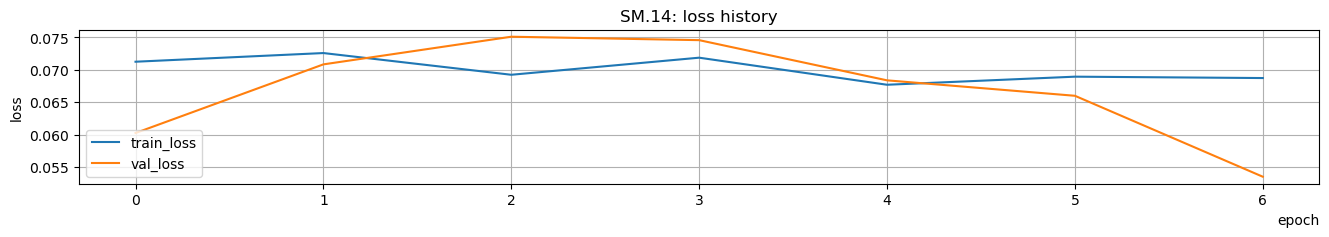

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 2))
history.show(ax)

In [ ]:
#-------------------------------------------------------------------------------------------------
epoch = 0
for train_loss, val_loss, recall, precision, learning_rate, time_taken \
    in zip(history.history['loss'], history.history['val_loss'], history.history['recall'], history.history['precision'], history.history['learning_rate'], history.history['time_taken']):
    # epoch, model, history, checkpointPath, checkpointPathBest, train_loss, val_loss, learning_rate, recall, precision, time_taken, playback=False
    _ = conclude_train_epoch(epoch, model_1x2, history, checkpointPath, checkpointPathBest, train_loss, val_loss, learning_rate, recall, precision, time_taken, playback = True)
    epoch += 1

EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
epoch: 0, train_loss: 0.071255766, val_loss: 0.060237661, recall/precision: 0.0602/0.0602, learning_rate: -1.00000e+00, time_taken: 30.8 m
----------------------------------------------------------------------------------------------------- best checkpoint updated
EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
epoch: 1, train_loss: 0.072596014, val_loss: 0.070846111, recall/precision: 0.0708/0.0708, learning_rate: -1.00000e+00, time_taken: 29.3 m
EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
epoch: 2, train_loss: 0.069240481, val_loss: 0.075119793, recall/precision: 0.0751/0.0751, learning_rate: -1.00000e+00, time_taken: 29.3 m
EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE

In [ ]:
# @tf.function  #-------------------- Weird: no work.
def train(epochs, nUpgrades, model, optimizer, history, checkpointPath, checkpointPathBest, train_ds, valid_batches, apply_train_pipeline, get_f1=False):
    epochs = epochs; seen_upgrades = 0
    for epoch in range(history.len(), history.len() + epochs):
        start_time = time.time()
        optimizer.step.assign(history.len()); learning_rate = optimizer.lr.numpy()
        n = 0; loss = tf.Variable(0.0, dtype=tf.float32); samples_seen = 0
        m = 0; train_loss = 0.0
        
        train_batches = apply_train_pipeline(train_ds)      # the pipeline includes suffle.
        for step, ((baseId, sequence, base_bb, baseDateDetails, mask), (value)) in enumerate(train_batches):
            x = (sequence, base_bb, baseDateDetails, mask); y = value
            samples_seen += sequence.shape[0]
            batch_loss, _ = train_step(model, optimizer, x, y)  # (), (batch,)
            n += 1; loss = loss * (n-1)/n + batch_loss/n
            m += 1; train_loss = train_loss * (m-1)/m + batch_loss/m
            if step % 50 == 0: show_steps(epoch, step, loss, samples_seen, learning_rate); n = 0; loss = 0.0

        show_steps(epoch, step, loss, samples_seen, learning_rate)  # closing show
        val_loss = find_loss_for_dataset(model, valid_batches)

        recall = precision = -1.0
        if get_f1: recall, precision = find_recall_precision(model, valid_batches); recall = recall.numpy(); precision = precision.numpy()
        
        # epoch, model, history, checkpointPath, checkpointPathBest, train_loss, val_loss, learning_rate, recall, precision, time_taken, playback=False
        upgraded = conclude_train_epoch(epoch, model, history, checkpointPath, checkpointPathBest, float(train_loss), float(val_loss), learning_rate, recall, precision, (time.time()-start_time)/60, playback=False)
        if upgraded: seen_upgrades += 1
        if seen_upgrades >= nUpgrades: break

    return seen_upgrades


In [48]:
if OPERATION == 'PRETRAIN': # model_1x2 is trained to find profitable staking vectors for games, although average profitability is far below zero.
    try:    model_1x2.load_weights(checkpointPath)
    except: pass    # The raw model_1x2 itself is the starting point.

    # Goal: get checkpointPathBest checkpoint, which is used as the starting checkpoint of both TRAIN_C and FINETUNE.
    wanted_upgrades = 1
    nUpgrades = train(30, wanted_upgrades, model_1x2, optimizer, history, checkpointPath, checkpointPathBest, train_ds, valid_batches, apply_train_pipeline, get_f1 = False)
    
    OPERATION = 'TRAIN_C'   # Certificate for the next operation

AB:  [(21.80811633169651, 897, 1201), (13.304506435990334, 1515, 1580), (4.465094558894634, 365, 394), (1.73897535353899, 532, 561), (1.5116239711642265, 301, 338)]


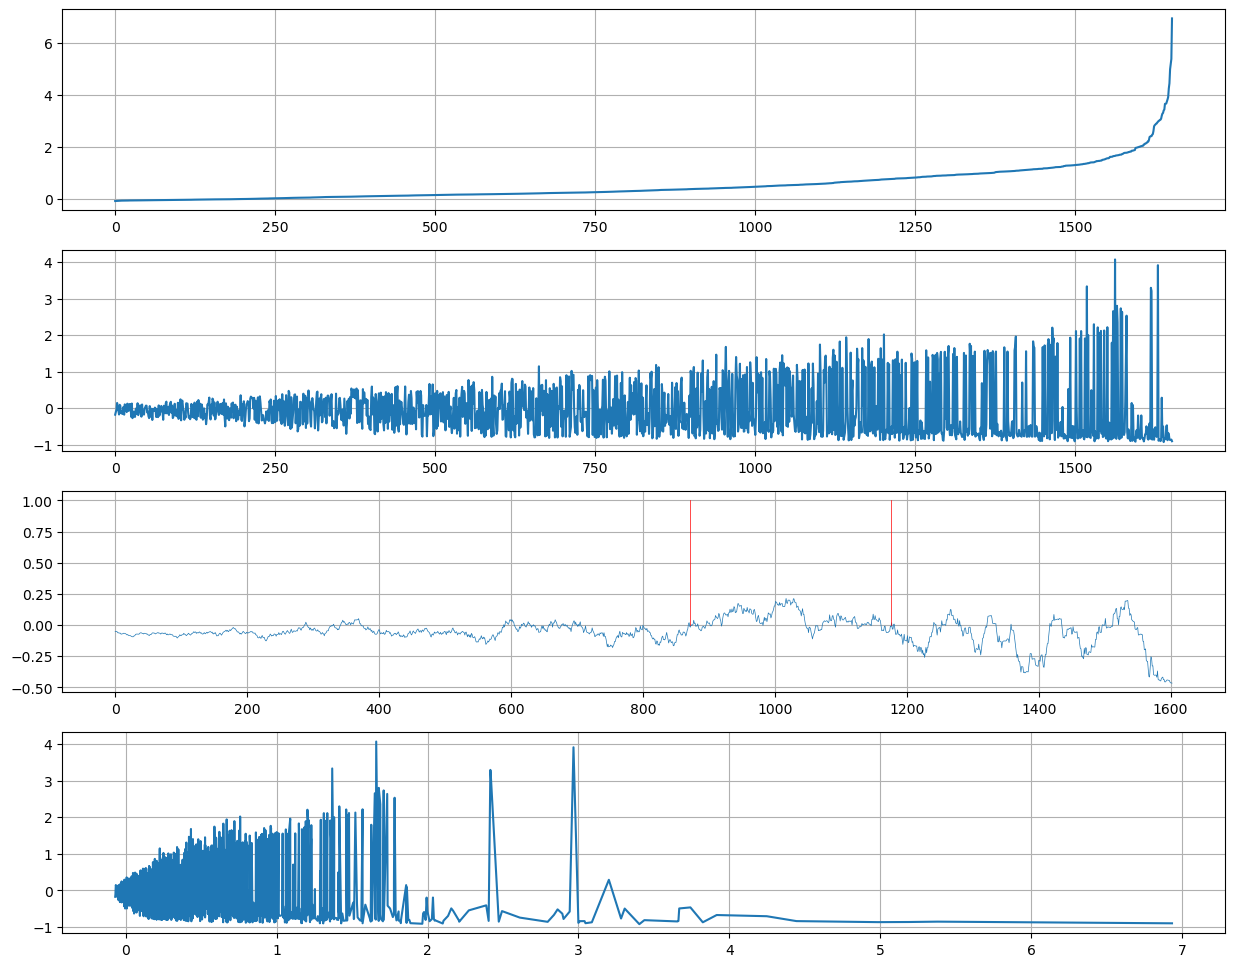

In [49]:
analyze(model_1x2, checkpointPathBest, test_batches)    # baseline

In [ ]:
checkpointPath_c = os.path.join(countryDirPath, '_checkpoints', TEST_ID + '_weights_c')
checkpointPathBest_c = os.path.join(countryDirPath, '_checkpoints', TEST_ID + '_weights_best_c')
historyPath_c = os.path.join(countryDirPath, '_checkpoints', TEST_ID + '_history_c.json')

if OPERATION == 'TRAIN_C':  # model_c is trained to find games for which model_1x2 can can find positively profitable staking vector.

    def X_versus_Y_c(baseId, sequence, base_bb, baseDateDetails, mask, profitable):
        return (baseId, sequence, base_bb, baseDateDetails, mask), (profitable)
    def apply_train_pipeline_c(ds):
        return (ds.shuffle(BUFFER_SIZE).batch(train_batch_size).map(X_versus_Y_c, tf.data.AUTOTUNE).cache().prefetch(buffer_size=tf.data.AUTOTUNE))
    def apply_test_pipeline_c(ds):
        return (ds.shuffle(BUFFER_SIZE).batch(test_batch_size).map(X_versus_Y_c, tf.data.AUTOTUNE).cache().prefetch(buffer_size=tf.data.AUTOTUNE))
    def create_replace_baseLabel_with_profitable(path, model, ds_batches, threshold=0.0001):     
        if os.path.exists(path):  ds = tf.data.Dataset.load(path)
        else: ds = replace_baseLabel_with_profitable(model, ds_batches, threshold=threshold); tf.data.Dataset.save(ds, path);  ds = tf.data.Dataset.load(path)
        return ds

    REPLACE_THRESHOLD = 0.00005
    model_1x2 = create_model_object(Model_1X2)
    model_1x2.load_weights(checkpointPathBest)    # finetuning model_1x2 starts from the best pretrained model_1x2.
    path_train_ds_with_profitable = os.path.join(countryDirPath, '_datasets', id_to_ids_filename + '-train_ds_with_profitable')
    train_ds_with_profitable = create_replace_baseLabel_with_profitable(path_train_ds_with_profitable, model_1x2, train_batches, threshold=REPLACE_THRESHOLD) # train_batches
    print("train len: ", len(train_ds_with_profitable))
    path_valid_ds_with_profitable = os.path.join(countryDirPath, '_datasets', id_to_ids_filename + '-valid_ds_with_profitable')
    valid_ds_with_profitable = create_replace_baseLabel_with_profitable(path_valid_ds_with_profitable, model_1x2, valid_batches, threshold=REPLACE_THRESHOLD) # valid_batches
    print("valid len: ", len(valid_ds_with_profitable))
    valid_batches_with_profitable = apply_test_pipeline_c(valid_ds_with_profitable)

    model_c = create_model_object(Model_Filter)
    try: model_c.load_weights(checkpointPath_c)
    except: model_c.load_weights(checkpointPathBest)    # model_c starts from the best pretrained model_1x2.
    # Goal: get checkpointPathBest_c checkpoint, which is used to filter datasets in favor of model_1x2
    wanted_upgrades = 1
    history_c = history_class(historyPath_c); history_c.load()
    optimizer_c = Adam_exponential(history.len(), STARTING_LEARNING_RATE/10, EXAMPLE_LEARNING_STEP, EXAMPLE_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-12)
    nUpgrades = train(10, wanted_upgrades, model_c, optimizer_c, history_c, checkpointPath_c, checkpointPathBest_c, train_ds_with_profitable, valid_batches_with_profitable, apply_train_pipeline_c, get_f1=True)

    OPERATION = 'FINETUNE'   # Certificate for the next operation

train len:  38773
valid len:  1649
EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
epoch: 1, train_loss: 0.967119873, val_loss: 1.022203088, recall/precision: 0.4314/0.3324, learning_rate: 1.67224e-08, time_taken: 31.7 m
EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEE
epoch: 2, train_loss: 0.982372701, val_loss: 0.956517100, recall/precision: 0.4802/0.3778, learning_rate: 2.79639e-08, time_taken: 30.5 m


In [ ]:
checkpointPath_f = os.path.join(countryDirPath, '_checkpoints', TEST_ID + '_weights_f')
checkpointPathBest_f = os.path.join(countryDirPath, '_checkpoints', TEST_ID + '_weights_best_f')
historyPath_f = os.path.join(countryDirPath, '_checkpoints', TEST_ID + '_history_f.json')

def filter_dataset_for_profitable_items(path, model, ds_batches, threshold=0.5):
    if path is None: ds = select_profitable_items(model, ds_batches, threshold=threshold)
    else:
        if os.path.exists(path):  ds = tf.data.Dataset.load(path)
        else: ds = select_profitable_items(model_c, ds_batches, threshold=threshold); tf.data.Dataset.save(ds, path);  ds = tf.data.Dataset.load(path)
    return ds

if OPERATION == 'FINETUNE': # model_1x2 is trained to find profitable staking vectors for games that are filtered in by model_c.
   
    model_c = create_model_object(Model_Filter)
    model_c.load_weights(checkpointPathBest_c)  # It's time to use the best classifier.

    FILTER_THRESHOLD = 0.5
    path_train_ds_filtered = os.path.join(countryDirPath, '_datasets', id_to_ids_filename + '-train_ds_filtered')
    train_ds_filtered = filter_dataset_for_profitable_items(path_train_ds_filtered, model_c, train_batches, threshold=FILTER_THRESHOLD)    # train_batches
    print("train len: ", len(train_ds_filtered))
    path_valid_ds_filtered = os.path.join(countryDirPath, '_datasets', id_to_ids_filename + '-valid_ds_filtered')
    valid_ds_filtered = filter_dataset_for_profitable_items(path_valid_ds_filtered, model_c, valid_batches, threshold=FILTER_THRESHOLD)    # valid_batches
    print("valid len: ", len(valid_ds_filtered))
    valid_batches_filtered = apply_test_pipeline(valid_ds_filtered)

    model_1x2 = create_model_object(Model_1X2)
    try: model_1x2.load_weights(checkpointPath_f)
    except: model_1x2.load_weights(checkpointPathBest)    # finetuned model_1x2 starts from the best pretrained model_1x2.
    # Goal: get checkpointPathBest_f checkpoint, which is used as our final model. The final model needs the dataset filter model_c as seen in 'TEST' operation.
    wanted_upgrades = 1
    history_f = history_class(historyPath_f); history_f.load()
    optimizer_f = Adam_exponential(history.len(), STARTING_LEARNING_RATE/10, EXAMPLE_LEARNING_STEP, EXAMPLE_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-12)
    nUpgrades = train(10, wanted_upgrades, model_1x2, optimizer_f, history_f, checkpointPath_f, checkpointPathBest_f, train_ds_filtered, valid_batches_filtered, apply_train_pipeline, get_f1 = False)

    OPERATION = 'TEST'   # Certificate for the next operation

In [ ]:
if OPERATION == 'TEST': # model_1x2, after pretrained and finetuned, is tested on a dataset that is filered in by model_c.
    model_c = create_model_object(Model_Filter)
    model_c.load_weights(checkpointPathBest_c)  # It's time to use the best classifier.

    FILTER_THRESHOLD = 0.5
    ds_filtered = filter_dataset_for_profitable_items(None, model_c, test_batches, threshold=0.5)
    ds_filtered_batches = apply_test_pipeline(ds_filtered)
    analyze(model_1x2, checkpointPathBest_f, ds_filtered_batches)  # compare with the baseline

In [ ]:
interval_a = 0.7    # Choose onefiltered_test_ds
interval_b = 0.8    # Choose one

if not TRAIN_MODE:      # just sketch
    # df_grown gets to be the existing df_grown, because the train_mode if False.
    df_total, df_new = df_grown, df_new = data_helpers.get_grown_and_new_from_football_data(countryDirPath, Required_Non_Odds_cols, NUMBER_BOOKIES, train_mode = TRAIN_MODE, skip=False)
    df_white = df_new
    df_black = data_helpers.read_excel(path)

    df_total = df_total; df_search = df_new
    additional_id_to_ids = data_helpers.fixture_id_to_ids_uk_maxflow(countryDirPath, targetLength, minCurrent, sinceDaysAgo, qualityPct, conductance365, df_total, df_search, chooseDivs=chooseDivs)
    
    ds_path = os.path.join(countryDirPath, '_datasets', id_to_ids_filename + '-dataset-inference')

    if os.path.exists(ds_path):
        ds = tf.data.Dataset.load(ds_path)
    else:
        ds = generate_dataset_uk(df_total, additional_id_to_ids, tokenizer_team, std_params, train_mode=False)  #-----------------                                                                          #-----------------
        tf.data.Dataset.save(ds, ds_path)       # This is the true line by which the dataset generator gets to work.
        ds = tf.data.Dataset.load(ds_path)      # Weird, this line is required. len(ds) would have no value!!!

    ds_inference = apply_test_pipeline(ds)
    stake_vectors = inference_with_dataset(ds_inference, interval_a, interval_b) # (batch, nBookies, nQueries)

